# 1. Configuraci√≥n de entorno

En esta secci√≥n validamos que nuestro entorno de trabajo est√© correctamente configurado antes de comenzar el an√°lisis.  
Los pasos incluyen:

1. **Versi√≥n de Python**  
   - Se verifica que est√© instalada la versi√≥n **3.11 o superior** (se recomienda 3.13).  
   - Esto garantiza compatibilidad con librer√≠as modernas de an√°lisis de datos y machine learning.

2. **Importaci√≥n de librer√≠as base**  
   - Se cargan librer√≠as fundamentales:  
     - `numpy`, `pandas`: manipulaci√≥n y an√°lisis de datos.  
     - `matplotlib`, `seaborn`: visualizaci√≥n de datos.  
     - `scipy`: funciones estad√≠sticas.  
   - Adem√°s se configuran estilos gr√°ficos y opciones de visualizaci√≥n en pandas para trabajar con tablas m√°s grandes.

3. **Verificaci√≥n de versiones cr√≠ticas**  
   - Se comprueba que `scikit-learn` est√© instalado y en una versi√≥n **>= 1.0.1**.  
   - Esto es esencial ya que `scikit-learn` se usar√° para el modelado (baseline y posteriores).

Con esta configuraci√≥n inicial aseguramos que el entorno sea reproducible y que todas las dependencias necesarias est√©n listas antes de continuar con el **EDA** y el **baseline**.


In [301]:
import sys
import warnings
warnings.filterwarnings('ignore')

assert sys.version_info >= (3, 11), "Este notebook trabajo con python 3.11 o superiores (recomendado 3.13)"

print(f"Python {sys.version_info.major}.{sys.version_info.minor} instalado correctamente")

Python 3.13 instalado correctamente


In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Librer√≠as importadas exitosamente")

Librer√≠as importadas exitosamente


In [303]:
# Verificar versiones de librer√≠as cr√≠ticas
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1"), "Requiere scikit-learn >= 1.0.1"
print(f"scikit-learn {sklearn.__version__} instalado")

scikit-learn 1.7.2 instalado


# 2. Metodolog√≠a CRISP-DM
## 2.1. Comprensi√≥n del Negocio
El problema de Google Play Store  

**Contexto:**  
Es 2025. El mercado de aplicaciones m√≥viles es altamente competitivo: millones de apps conviven en Google Play Store.  
Los desarrolladores buscan mejorar la visibilidad de sus aplicaciones y los usuarios dependen del **rating promedio** para decidir qu√© descargar.  

**Problema actual:**  
- El rating se conoce **solo despu√©s** de que los usuarios descargan y rese√±an.  
- Las valoraciones son **altamente variables** y pueden depender de m√∫ltiples factores (categor√≠a, descargas, precio, tama√±o, tipo de app).  
- Los desarrolladores carecen de una herramienta para **estimar la calificaci√≥n potencial** de una app antes o durante su lanzamiento.  
- La competencia es muy alta: una diferencia de d√©cimas en rating puede significar miles de descargas menos.  

---

### 2.1.1. Soluci√≥n propuesta  
Construir un **sistema autom√°tico de predicci√≥n de rating** de apps a partir de sus caracter√≠sticas disponibles en el dataset de Google Play Store.  

---

### 2.1.2. Definiendo el √©xito  

**M√©trica de negocio:**  
- Ayudar a los desarrolladores a anticipar la valoraci√≥n probable de su app.  
- Reducir la dependencia de pruebas de mercado costosas o lentas.  
- Identificar caracter√≠sticas clave que favorecen una alta valoraci√≥n (‚â• 4.3).  

**M√©trica t√©cnica:**  
- Lograr un **Error Absoluto Medio (MAE) < 0.5 estrellas** en la predicci√≥n de rating.  
- Para la versi√≥n de clasificaci√≥n (alta vs. baja calificaci√≥n): obtener un **F1-score > 0.70**.  

**¬øPor qu√© estos valores?**  
- El rating va de 1 a 5 ‚Üí un error de 0.5 equivale a 10% de la escala.  
- Una diferencia de medio punto puede marcar la visibilidad de la app en el ranking.  
- Tasadores humanos (usuarios) tambi√©n muestran variabilidad similar en sus calificaciones.  

---

### 2.1.3 Preguntas cr√≠ticas antes de empezar  

1. **¬øRealmente necesitamos ML?**  
   - Alternativa 1: Calcular el promedio de ratings por categor√≠a ‚Üí demasiado simple, no captura variabilidad.  
   - Alternativa 2: Reglas heur√≠sticas (ej. ‚Äúsi es gratis y tiene muchas descargas, tendr√° rating alto‚Äù) ‚Üí insuficiente.  
   - **Conclusi√≥n:** S√≠, ML es apropiado para capturar relaciones no lineales y m√∫ltiples factores.  

2. **¬øQu√© pasa si el modelo falla?**  
   - Transparencia: aclarar que es una estimaci√≥n autom√°tica.  
   - Complementar con rangos de predicci√≥n (ej: intervalo de confianza).  
   - Mantener como referencia comparativa, no como √∫nico criterio de √©xito.  

3. **¬øC√≥mo mediremos el impacto?**  
   - Capacidad de anticipar apps con alta probabilidad de √©xito.  
   - Ahorro de tiempo en validaciones preliminares.  
   - Insights para desarrolladores sobre qu√© factores influyen m√°s en el rating.  

---


## 2.2. Comprensi√≥n de los Datos  

El objetivo de esta fase es explorar y entender el dataset de Google Play Store antes de construir modelos **(an√°lisis exploratorio)**.  
Nos centraremos en:  

1. **Vista r√°pida del dataset**  
   - Identificar dimensiones (filas √ó columnas).  
   - Tipos de datos (num√©ricos, categ√≥ricos, texto, fechas).  
   - Valores faltantes obvios y rangos sospechosos.

2. **Descripci√≥n de variables**  
   - Revisar cada columna y entender su significado.  
   - Detectar qu√© variables podr√≠an ser √∫tiles como predictores y cu√°l ser√° la variable objetivo (rating).  

3. **Detecci√≥n de problemas en los datos**  
   - An√°lisis de valores faltantes.  
   - Estrategias: eliminar filas/columnas, imputar valores o crear indicadores de ‚Äúdato faltante‚Äù.  

4. **Estad√≠sticas descriptivas y univariadas**  
   - Media vs mediana (sesgo de la distribuci√≥n).  
   - Desviaci√≥n est√°ndar (variabilidad, posibles outliers).  
   - M√≠nimos/m√°ximos sospechosos.  
   - Histogramas para ver forma (normal, sesgada, bimodal, uniforme, picos extra√±os).  

5. **An√°lisis de variables categ√≥ricas**  
   - Distribuci√≥n de categor√≠as (ej. categor√≠as de apps, tipo de app, content rating).  
   - Detecci√≥n de clases dominantes o categor√≠as poco representadas.  

6. **Correlaciones y relaciones entre variables**  
   - Matriz de correlaci√≥n de Pearson para variables num√©ricas.  
   - Identificar relaciones fuertes, moderadas o d√©biles.  
   - Importante: recordar que **correlaci√≥n ‚â† causalidad**.  
7. **An√°lisis de outliers**
   -  Tipos e identificaci√≥n de outliers a trav√©s de diferentes m√©todos.

---

**Nota:**  
No siempre es necesario aplicar todos los pasos con igual profundidad.  
- Para este proyecto, el foco est√° en **identificar variables relevantes para predecir el rating** y **limpiar datos inconsistentes**.  
- Otros an√°lisis m√°s complejos (ej. NLP sobre descripciones) se pueden dejar como trabajo futuro (seg√∫n trabajos de referencia investigados).

---


### 2.2.1 Descarga de datos  

En este paso descargamos el dataset de Google Play Store desde Kaggle y lo organizamos en la estructura de carpetas del proyecto.  

1. Usamos la librer√≠a `kagglehub` para acceder al dataset p√∫blico **`lava18/google-play-store-apps`** directamente desde Kaggle.  
2. Se define una ruta clara dentro del proyecto para almacenar los datos originales: `../data/original/google-play-store/`. Esto ayuda a mantener la reproducibilidad y una estructura organizada.  
3. Con la funci√≥n `shutil.copytree` copiamos los archivos descargados a la carpeta destino. De esta forma, el dataset queda disponible en nuestro directorio de trabajo para su an√°lisis posterior.  


In [304]:
import kagglehub
import shutil

def download_data(origin_repository, target_folder):
    # Descargar dataset
    path = kagglehub.dataset_download(origin_repository)
    
    # Copiar los archivos descargados
    shutil.copytree(path, target_folder, dirs_exist_ok=True)
    

download_data("lava18/google-play-store-apps", "../../data/original/google-play-store")

### 2.2.2 Carga de datos  

En este paso realizamos la **lectura del archivo CSV** que contiene el dataset descargado previamente.  

- Definimos una funci√≥n `load_data(path, file)` que recibe la ruta y el nombre del archivo, y lo carga con `pandas.read_csv()`.  
- Cargamos el dataset principal en la variable `applications_data` desde la carpeta `../data/original/google-play-store/`.  
- Incluimos una verificaci√≥n simple:  
  - Si el dataset se carga con √©xito, se imprime `"Dataset loaded"`.  
  - En caso contrario, se muestra un mensaje de error.  

Con esta validaci√≥n aseguramos que el archivo est√© disponible y correctamente le√≠do antes de continuar con el an√°lisis exploratorio.


In [305]:
import pandas as pd
import numpy as np

def load_data(path, file):
    return pd.read_csv(f"{path}/{file}")

def convert_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convierte a num√©ricas solo las columnas que deber√≠an serlo, sin tocar 'Size'.
    Usa to_numeric(errors='coerce') para evitar ValueError si aparece texto.
    """
    df = df.copy()

    # Rating
    if "Rating" in df.columns:
        df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

    # Reviews: quitar comas y cualquier car√°cter no num√©rico/punto
    if "Reviews" in df.columns:
        df["Reviews"] = (
            df["Reviews"].astype(str)
            .str.replace(r"[^\d.]", "", regex=True)
            .pipe(pd.to_numeric, errors="coerce")
        )

    # Installs: quitar +, comas y cualquier car√°cter no num√©rico/punto
    if "Installs" in df.columns:
        df["Installs Numeric"] = (
            df["Installs"].astype(str)
            .str.replace(r"[^\d.]", "", regex=True)
            .pipe(pd.to_numeric, errors="coerce")
        )

    # Price: quitar $ y cualquier car√°cter no num√©rico/punto
    if "Price" in df.columns:
        df["Price"] = (
            df["Price"].astype(str)
            .str.replace(r"[^\d.]", "", regex=True)
            .pipe(pd.to_numeric, errors="coerce")
        )


    if "Size" in df.columns:
        def parse_size(x):
            if isinstance(x, str):
                x = x.strip()
                if x.endswith("M"):
                    return float(x[:-1])
                elif x.endswith("k") or x.endswith("K"):
                    return float(x[:-1]) / 1024  # KB -> MB
                else:
                    return np.nan
            return np.nan
        df["Size"] = df["Size"].apply(parse_size)

    return df


temp_applications_data = load_data("../../data/original/google-play-store", "googleplaystore.csv")
applications_data = convert_numeric_columns(temp_applications_data)


if len(applications_data):
    print("Dataset cargado")
else:
    print("Error cargando dataset")


Dataset cargado


### 2.2.3 Vista r√°pida del dataset

**Dimensiones y columnas**
- Registros: **10,841** filas.
- Columnas: actualmente **14**; **originalmente eran 13** y se **a√±adi√≥** una columna derivada: **`Installs Numeric`** para an√°lisis con describe.
- Memoria aproximada: **~1.2 MB**.

**Tipos de datos (y transformaciones realizadas)**
- Num√©ricas (`float64`): `Rating`, `Reviews`, `Size`, `Price`, **`Installs Numeric`**.
- Categ√≥ricas / texto (`object`): `App`, `Category`, `Installs` *(forma original con ‚Äú1,000+‚Äù)*, `Type`, `Content Rating`, `Genres`, `Last Updated`, `Current Ver`, `Android Ver`.
- Transformaciones ya aplicadas:
  - **`Installs`** se **conserv√≥** en su formato original (categ√≥rico con ‚Äú+‚Äù y comas) **y** se cre√≥ **`Installs Numeric`** mapeando esos rangos a n√∫meros (0 ‚Ä¶ 1,000,000,000).
  - **`Price`**, **`Reviews`** y **`Size`** fueron normalizadas/parseadas a **num√©rico** para an√°lisis y modelado.

**Valores faltantes (no-null count ‚Üí faltantes aprox.)**
- `Rating`: 9,367 ‚Üí **1,474 faltantes (~13.6%)**.
- `Size`: 9,145 ‚Üí **1,696 faltantes (~15.6%)**.
- `Current Ver`: 10,833 ‚Üí **8 faltantes (~0.07%)**.
- `Android Ver`: 10,838 ‚Üí **3 faltantes (~0.03%)**.
- `Content Rating`: 10,840 ‚Üí **1 faltante (~0.01%)**.
- `Price`: 10,840 ‚Üí **1 faltante (~0.01%)**.
- `Installs Numeric`: 10,840 ‚Üí **1 faltante (~0.01%)**.
- Resto de columnas: **sin faltantes**.

**Duplicados:**
-   Se identificaron **483 filas duplicadas** (‚âà **4.46%** del
    dataset).\
-   Ejemplos de duplicados incluyen apps como:
    -   *Quick PDF Scanner + OCR FREE*\
    -   *Box*\
    -   *Google My Business*\
    -   *ZOOM Cloud Meetings*\
    -   *join.me -- Simple Meetings*\

**Rangos y valores sospechosos (seg√∫n `describe()`)**
- `Rating`: **min = 1.0**, **max = 19.0** ‚Üí **19** es inv√°lido para la escala 1‚Äì5 (error de dato a corregir).
- `Reviews`: media ~ **444k**, **p75 ‚âà 54,768**, **max ‚âà 78M** ‚Üí valores altos plausibles; tratar como **outliers**.
- `Size` (MB): media ~ **21.5**, **p50 = 13**, **p75 = 30**, **max = 100** ‚Üí distribuci√≥n sesgada a la derecha; m√≠nimos muy bajos (**0.01**) a revisar.
- `Price` (USD): **mediana = 0** y **p75 = 0** ‚Üí la mayor√≠a son **apps gratuitas**; **max = 400** sugiere outliers de precio.
- `Installs Numeric`: **p25 = 1,000**, **p50 = 100,000**, **p75 = 5,000,000**, **max = 1,000,000,000** ‚Üí escala muy amplia; conviene usar **transformaciones log** o **binning** en el EDA/modelado.

**Conclusi√≥n inicial**
- Los **faltantes** m√°s relevantes est√°n en `Rating` y `Size`; habr√° que decidir estateg√≠a para aumentar, imputar o nivelar los datos.
- Existen **outliers (no leg√≠timos)** (ej. `Rating = 19`) y variables con **colas largas** (ej. `Reviews`, `Installs Numeric`, `Price`).
- Eliminar **duplicados** para evitar sesgos de an√°lisis y que no introduzcan ruidos.


In [6]:
print("=" * 80)
print("INFORMACI√ìN GENERAL DEL DATASET".center(80))
print("=" * 80)

display(applications_data.head().style.background_gradient(cmap='RdYlGn', subset=['Rating']))

# Informaci√≥n detallada
print("\n" + "=" * 80)
print("ESTRUCTURA DE DATOS".center(80))
print("=" * 80)
applications_data.info()

# Estad√≠sticas descriptivas
print("\n" + "=" * 80)
print("ESTAD√çSTICAS DESCRIPTIVAS".center(80))
print("=" * 80)
display(applications_data.describe().round(2).T)

print("\n" + "=" * 80)
print("DATOS DUPLICADOS".center(80))
print("=" * 80)

# Contar duplicados
num_duplicados = applications_data.duplicated().sum()
print(f"Total de registros duplicados: {num_duplicados}")

# Mostrar ejemplos de duplicados si existen
if num_duplicados > 0:
    print("\nEjemplos de filas duplicadas:\n")
    display(applications_data[applications_data.duplicated()].head())
else:
    print("No se encontraron registros duplicados.")


                        INFORMACI√ìN GENERAL DEL DATASET                         



                              ESTRUCTURA DE DATOS                               
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   App               10841 non-null  object 
 1   Category          10841 non-null  object 
 2   Rating            9367 non-null   float64
 3   Reviews           10841 non-null  float64
 4   Size              9145 non-null   float64
 5   Installs          10841 non-null  object 
 6   Type              10840 non-null  object 
 7   Price             10840 non-null  float64
 8   Content Rating    10840 non-null  object 
 9   Genres            10841 non-null  object 
 10  Last Updated      10841 non-null  object 
 11  Current Ver       10833 non-null  object 
 12  Android Ver       10838 non-null  object 
 13  Installs Numeric  10840 non-null  float64
dtypes: float64(5), object(9)
memory usage: 1.2+ MB

    

count        mean         std  min     25%       50%  \
Rating            9367.00        4.19        0.54 1.00    4.00      4.30   
Reviews          10841.00   444111.93  2927628.66 0.00   38.00   2094.00   
Size              9145.00       21.52       22.59 0.01    4.90     13.00   
Price            10840.00        1.03       15.95 0.00    0.00      0.00   
Installs Numeric 10840.00 15464338.88 85029361.40 0.00 1000.00 100000.00   

                        75%           max  
Rating                 4.50         19.00  
Reviews            54768.00   78158306.00  
Size                  30.00        100.00  
Price                  0.00        400.00  
Installs Numeric 5000000.00 1000000000.00


                                DATOS DUPLICADOS                                
Total de registros duplicados: 483

Ejemplos de filas duplicadas:



App  Category  Rating   Reviews  Size  \
229  Quick PDF Scanner + OCR FREE  BUSINESS    4.20  80805.00   NaN   
236                           Box  BUSINESS    4.20 159872.00   NaN   
239            Google My Business  BUSINESS    4.40  70991.00   NaN   
256           ZOOM Cloud Meetings  BUSINESS    4.40  31614.00 37.00   
261     join.me - Simple Meetings  BUSINESS    4.00   6989.00   NaN   

        Installs  Type  Price Content Rating    Genres       Last Updated  \
229   5,000,000+  Free   0.00       Everyone  Business  February 26, 2018   
236  10,000,000+  Free   0.00       Everyone  Business      July 31, 2018   
239   5,000,000+  Free   0.00       Everyone  Business      July 24, 2018   
256  10,000,000+  Free   0.00       Everyone  Business      July 20, 2018   
261   1,000,000+  Free   0.00       Everyone  Business      July 16, 2018   

            Current Ver         Android Ver  Installs Numeric  
229  Varies with device        4.0.3 and up        5000000.00  
236  Varies with device  Varies with device       10000000.00  
239    2.19.0.204537701          4.4 and up        5000000.00  
256      4.1.28165.0716          4.0 and up       10000000.00  
261           4.3.0.508          4.4 and up        1000000.00

### 2.2.4 Descripci√≥n de las variables

In [7]:
variables = [
    'App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price',
    'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver',
    'Installs Numeric'
]

tipos = [
    'Categ√≥rica',          # App
    'Categ√≥rica',          # Category
    'Num√©rica (Target)',   # Rating
    'Num√©rica',            # Reviews
    'Num√©rica (MB)',       # Size
    'Categ√≥rica (rango)',  # Installs
    'Categ√≥rica',          # Type
    'Num√©rica (USD)',      # Price
    'Categ√≥rica',          # Content Rating
    'Categ√≥rica',          # Genres
    'Texto (fecha)',       # Last Updated (parseable a fecha)
    'Texto',               # Current Ver
    'Texto',               # Android Ver
    'Num√©rica',            # Installs Numeric
]

descripciones = [
    'Nombre de la aplicaci√≥n.',
    'Categor√≠a oficial de la app en Google Play.',
    'Calificaci√≥n promedio de usuarios (1 a 5).',
    'N√∫mero de rese√±as reportadas.',
    'Tama√±o aproximado de la app en MB.',
    'Instalaciones en rango (p.ej., "1,000+").',
    'Tipo de app (Free / Paid).',
    'Precio en USD (0 para gratuitas).',
    'Clasificaci√≥n de contenido (Everyone, Teen, etc.).',
    'G√©nero(s) de la app.',
    'Fecha de √∫ltima actualizaci√≥n (texto en origen).',
    'Versi√≥n actual declarada por el desarrollador.',
    'Versi√≥n m√≠nima de Android requerida.',
    'Instalaciones convertidas a n√∫mero para an√°lisis.'
]

valores_faltantes = [applications_data[col].isnull().sum() if col in applications_data.columns else None for col in variables]

metadata = {
    'Variable': variables,
    'Tipo': tipos,
    'Descripci√≥n': descripciones,
    'Valores Faltantes': valores_faltantes
}

df_metadata = pd.DataFrame(metadata)

# Mostrar con resaltado de faltantes
styled = df_metadata.style.applymap(
    lambda x: 'background-color: #ffcccc' if isinstance(x, (int, float)) and x > 0 else '',
    subset=['Valores Faltantes']
)

display(styled)

# Resumen de dtypes originales (informativo)
dtypes_resumen = applications_data[variables].dtypes.astype(str).reset_index()
dtypes_resumen.columns = ['Variable', 'dtype pandas']
display(dtypes_resumen)

Variable dtype pandas
0                App       object
1           Category       object
2             Rating      float64
3            Reviews      float64
4               Size      float64
5           Installs       object
6               Type       object
7              Price      float64
8     Content Rating       object
9             Genres       object
10      Last Updated       object
11       Current Ver       object
12       Android Ver       object
13  Installs Numeric      float64

### 2.2.5 Detecci√≥n de problemas en los datos 

**Resumen de hallazgos (valores faltantes):**
- `Size` ‚âà 15.6% y `Rating` ‚âà 13.6% concentran la mayor√≠a de los faltantes.
- Faltantes puntuales (‚âà0.01%): `Type`, `Price`, `Content Rating`, `Installs Numeric` ocurren en la misma(s) fila(s) ‚Üí patr√≥n conjunto.
- `Android Ver` (0.03%) y `Current Ver` (0.07%) con faltantes residuales, parcialmente correlacionados con el grupo anterior.

**Heatmap de correlaci√≥n de patrones de faltantes (interpretaci√≥n):**
- Correlaci√≥n 1.00 entre `Type`, `Price`, `Content Rating`, `Installs Numeric`: las ausencias co-ocurren en el/los mismos registros. Acciones coordinadas.
- `Android Ver` muestra correlaci√≥n moderada (~0.58) con ese grupo: algunas veces falta junto con ellos.
- `Size`, `Rating`, `Current Ver` tienen patrones de faltantes independientes del grupo anterior (correlaciones cercanas a 0), lo que sugiere causas distintas.

#### Posibles estrategias de correcci√≥n

- Limpieza b√°sica
  - Eliminar duplicados (483 filas) para evitar sesgos.
  - Validar y corregir outliers imposibles, p. ej., `Rating = 19` ‚Üí convertir a NaN para tratarlo como faltante.

- Imputaci√≥n (conservadora y por grupos)
  - `Rating` (target): para modelado, eliminar filas sin `Rating`; para EDA descriptivo, imputar mediana por `Category` solo para visualizaci√≥n.
  - `Size`: imputar mediana por `Category √ó Type` y crear indicador `size_missing`.
  - `Android Ver`, `Current Ver`: imputar moda por `Category` y crear indicadores `androidver_missing`, `currentver_missing`.
  - Faltantes conjuntos (`Type`, `Price`, `Content Rating`, `Installs Numeric`):
    - Si es 1 fila: eliminarla es lo m√°s simple y seguro.
    - Alternativa (si se prefiere imputar):
      - `Type`: inferir desde `Price` (0 ‚Üí Free, >0 ‚Üí Paid).
      - `Price`: 0 si `Type == Free`, si `Paid` usar mediana por `Category`.
      - `Content Rating`: moda por `Category`.
      - `Installs Numeric`: mediana por `Category √ó Type` o por bin de `Installs`.



#### Estrategias de ‚Äúnivelaci√≥n‚Äù seg√∫n los porcentajes observados

- Size (~15.6% faltantes, >5% y <<60%)
  - Acci√≥n: imputar mediana por grupo `Category √ó Type`.
  - A√±adir flag: `size_missing = 1` cuando falte (conserva se√±al de ausencia).
  - Justificaci√≥n: volumen relevante; la mediana por grupos respeta diferencias entre tipos/categor√≠as.

- Rating (~13.6% faltantes, >5% y <<60%) [variable objetivo]
  - Para modelado: eliminar filas sin `Rating` (evita sesgo por imputaci√≥n del target).
  - Para EDA descriptivo: si se requiere visualizar completos, imputar mediana por `Category` solo para gr√°ficos/tablas (no para entrenamiento).
  - Justificaci√≥n: imputar el target puede distorsionar m√©tricas.

- Current Ver (0.07%) y Android Ver (0.03%) (<5%)
  - Acci√≥n: imputar con la moda por `Category`. Flags opcionales `currentver_missing` y `androidver_missing`.
  - Justificaci√≥n: impacto √≠nfimo; moda es suficiente y estable.

- Faltantes ‚Äúen bloque‚Äù en la misma fila: Type, Price, Content Rating, Installs Numeric (‚âà0.01% cada uno; correlaci√≥n 1.00)
  - Si es 1 fila: eliminarla directamente.
  - Si hubiera m√°s en el futuro y se prefiriera imputar coordinadamente:
    - `Type` desde `Price` (0 ‚Üí Free, >0 ‚Üí Paid),
    - `Price` = 0 si `Free`, si `Paid` usar mediana por `Category`,
    - `Content Rating` = moda por `Category`,
    - `Installs Numeric` = mediana por `Category √ó Type`.
  - Justificaci√≥n: co-ocurren; eliminar 1 fila no afecta el conjunto y evita inconsistencias.

- Transformaciones para estabilizar distribuciones (complementarias a la imputaci√≥n)
  - `Reviews` y `Installs Numeric`: aplicar `log1p` para an√°lisis y futuros modelos. *****************************
  - `Installs` (rangos): tratar como ordinal/bins en el EDA.

- Limpieza previa necesaria
  - Eliminar duplicados (483 filas).
  - Corregir valores imposibles detectados en el EDA (ej. `Rating = 19` ‚Üí NaN) y re-entrar al flujo de imputaci√≥n/nivelaci√≥n anterior.

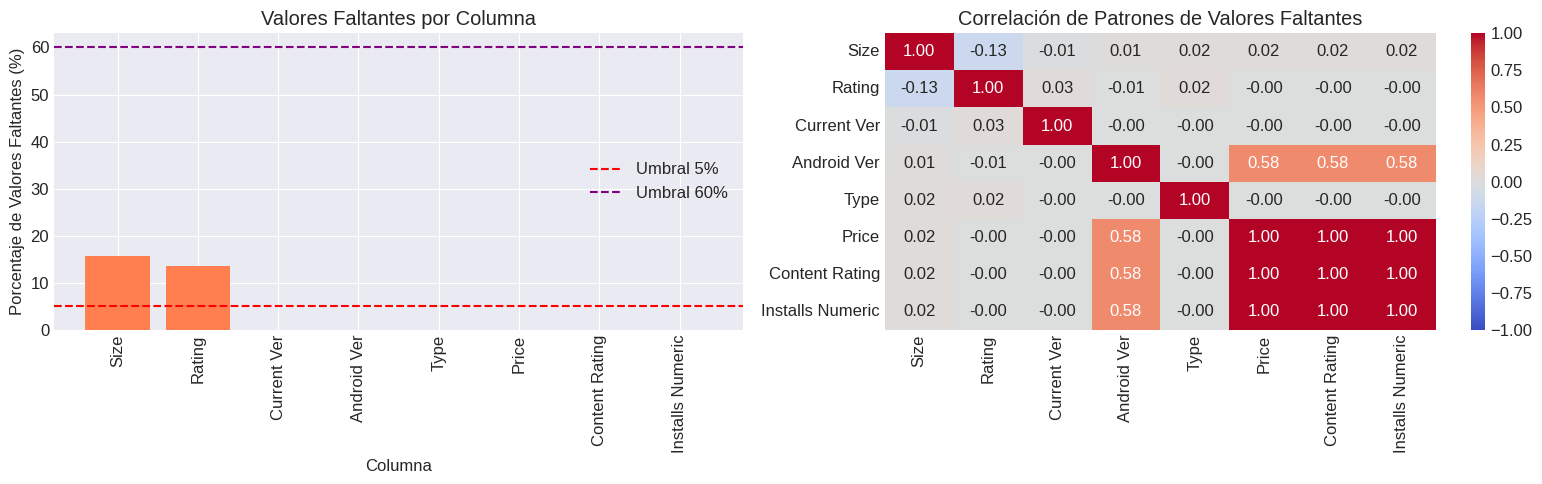

Columna  Valores_Faltantes  Porcentaje Tipo_Dato
4               Size               1696       15.64   float64
2             Rating               1474       13.60   float64
11       Current Ver                  8        0.07    object
12       Android Ver                  3        0.03    object
6               Type                  1        0.01    object
7              Price                  1        0.01   float64
8     Content Rating                  1        0.01    object
13  Installs Numeric                  1        0.01   float64

In [8]:
def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """An√°lisis completo de valores faltantes con visualizaciones."""
    missing_counts = df.isnull().sum()
    missing_pct = (missing_counts / len(df)) * 100

    missing_df = pd.DataFrame({
        'Columna': df.columns,
        'Valores_Faltantes': missing_counts.values,
        'Porcentaje': missing_pct.values,
        'Tipo_Dato': df.dtypes.values
    })

    missing_df = missing_df[missing_df['Valores_Faltantes'] > 0].sort_values('Porcentaje', ascending=False)

    if len(missing_df) == 0:
        print("No hay valores faltantes en el dataset")
        return missing_df

    # Visualizaci√≥n: barras y correlaci√≥n de patrones de faltantes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Gr√°fico de barras de % faltantes
    ax1.bar(missing_df['Columna'], missing_df['Porcentaje'], color='coral')
    ax1.set_xlabel('Columna')
    ax1.set_ylabel('Porcentaje de Valores Faltantes (%)')
    ax1.set_title('Valores Faltantes por Columna')
    ax1.axhline(y=5, color='r', linestyle='--', label='Umbral 5%')
    ax1.axhline(y=60, color='purple', linestyle='--', label='Umbral 60%')
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend()

    # Heatmap de correlaci√≥n de patrones de faltantes
    mask_df = df[missing_df['Columna'].tolist()].isnull().astype(int)
    if mask_df.shape[1] >= 2:
        corr = mask_df.corr()
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
        ax2.set_title('Correlaci√≥n de Patrones de Valores Faltantes')
    else:
        ax2.axis('off')
        ax2.set_title('Correlaci√≥n de faltantes (no aplica: 1 columna)')

    plt.tight_layout()
    plt.show()

    return missing_df

missing_analysis = analyze_missing_values(applications_data)
if missing_analysis is not None and not missing_analysis.empty:
    display(missing_analysis)

### 2.2.6 Estadisticas descriptivas y univariadas (n√∫merico)

A partir de la tabla de estad√≠sticas y los gr√°ficos generados para `Rating`, `Reviews`, `Size`, `Price` e `Installs Numeric`, se observan los siguientes puntos clave.

- Rating
  - Media ‚âà 4.19 y mediana ‚âà 4.30 ‚Üí ligera cola a la izquierda (m√°s apps con rating alto). Hay un valor imposible (‚âà19), confirmado en el boxplot/Q-Q como outlier extremo.
  - Outliers: ~5% por IQR, dominados por el valor inv√°lido y algunos ratings bajos.
  - Q-Q plot: desviaci√≥n frente a normalidad, esperable para una variable acotada [1,5].
  - Implicaci√≥n/acci√≥n: eliminar filas sin `Rating` para modelado; corregir `Rating=19 ‚Üí NaN` y excluir; no aplicar transformaciones (la escala es ya interpretables).

- Reviews
  - Media ‚â´ mediana (pico en 0‚Äìpocos miles; m√°ximo ‚âà 78M) ‚Üí cola muy larga a la derecha.
  - Boxplot: ~18% outliers por IQR (muchas apps con rese√±as muy altas).
  - Q-Q plot: gran desviaci√≥n de normalidad (heavy tail).
  - Relaci√≥n con Rating: correlaci√≥n positiva muy d√©bil (~0.07), tendencia casi plana.
  - Implicaci√≥n/acci√≥n: usar `log1p(Reviews)` para estabilizar la distribuci√≥n en an√°lisis/modelado; considerar winsorizar p99.9 para vistas tabulares si se desea.

- Size (MB)
  - Media > mediana (‚âà 21.5 vs 13) ‚Üí sesgo a la derecha; valores hasta 100 MB.
  - ~6% outliers por IQR, especialmente en colas altas.
  - Q-Q plot: curvatura en colas; no normal.
  - Relaci√≥n con Rating: correlaci√≥n positiva d√©bil (~0.08); se√±al muy tenue.
  - Implicaci√≥n/acci√≥n: imputar faltantes por `Category √ó Type` y a√±adir `size_missing`; opcionalmente probar `log1p(Size)` o binning para robustecer.

- Price (USD)
  - Mediana = 0 (mayor√≠a gratis) y cola a la derecha con m√°ximos altos (‚âà 400).
  - ~7% outliers por IQR; Q-Q muestra heavy tail.
  - Relaci√≥n con Rating: correlaci√≥n negativa muy d√©bil (~-0.02).
  - Implicaci√≥n/acci√≥n: crear `is_free = (Price == 0)` y, si se usa `Price` continuo, considerar `log1p(Price)` para las pocas apps pagas; validar coherencia `Type=Free ‚áí Price=0`.

- Installs Numeric
  - Media ‚â´ mediana (100k) con m√°ximo 1e9 ‚Üí distribuci√≥n extremadamente sesgada a la derecha.
  - ~7‚Äì8% outliers por IQR; Q-Q muy alejado de normalidad.
  - Relaci√≥n con Rating: correlaci√≥n d√©bil positiva (~0.05) y tendencia casi plana.
  - Implicaci√≥n/acci√≥n: usar `log1p(Installs Numeric)` o bins ordinales para an√°lisis; verificar coherencia con `Installs` textual.

Recomendaciones transversales
- Eliminar duplicados antes de resumir para evitar sesgos.
- Tratar outliers evidentes no-leg√≠timos (p. ej. `Rating=19`). Para colas largas leg√≠timas (`Reviews`, `Installs Numeric`, `Price`): preferir `log1p` o winsorizaci√≥n solo para visualizaciones.
- Mantener consistencia: `Type=Free ‚áí Price=0`; `Installs Numeric` coherente con el rango de `Installs`.
- Para relaciones con `Rating`, las correlaciones lineales observadas son d√©biles; la se√±al puede emerger mejor con interacciones (p. ej., `is_free √ó installs_bin`) o modelos no lineales.



count        mean         std  min     25%       50%  \
Rating            9367.00        4.19        0.54 1.00    4.00      4.30   
Reviews          10841.00   444111.93  2927628.66 0.00   38.00   2094.00   
Size              9145.00       21.52       22.59 0.01    4.90     13.00   
Price            10840.00        1.03       15.95 0.00    0.00      0.00   
Installs Numeric 10840.00 15464338.88 85029361.39 0.00 1000.00 100000.00   

                        75%           max      mad  skew  kurtosis    cv  
Rating                 4.50         19.00     0.20  0.60     66.00  0.13  
Reviews            54768.00   78158306.00  2094.00 16.45    341.09  6.59  
Size                  30.00        100.00     9.70  1.56      1.92  1.05  
Price                  0.00        400.00     0.00 23.71    578.14 15.53  
Installs Numeric 5000000.00 1000000000.00 99990.00  9.57    100.28  5.50

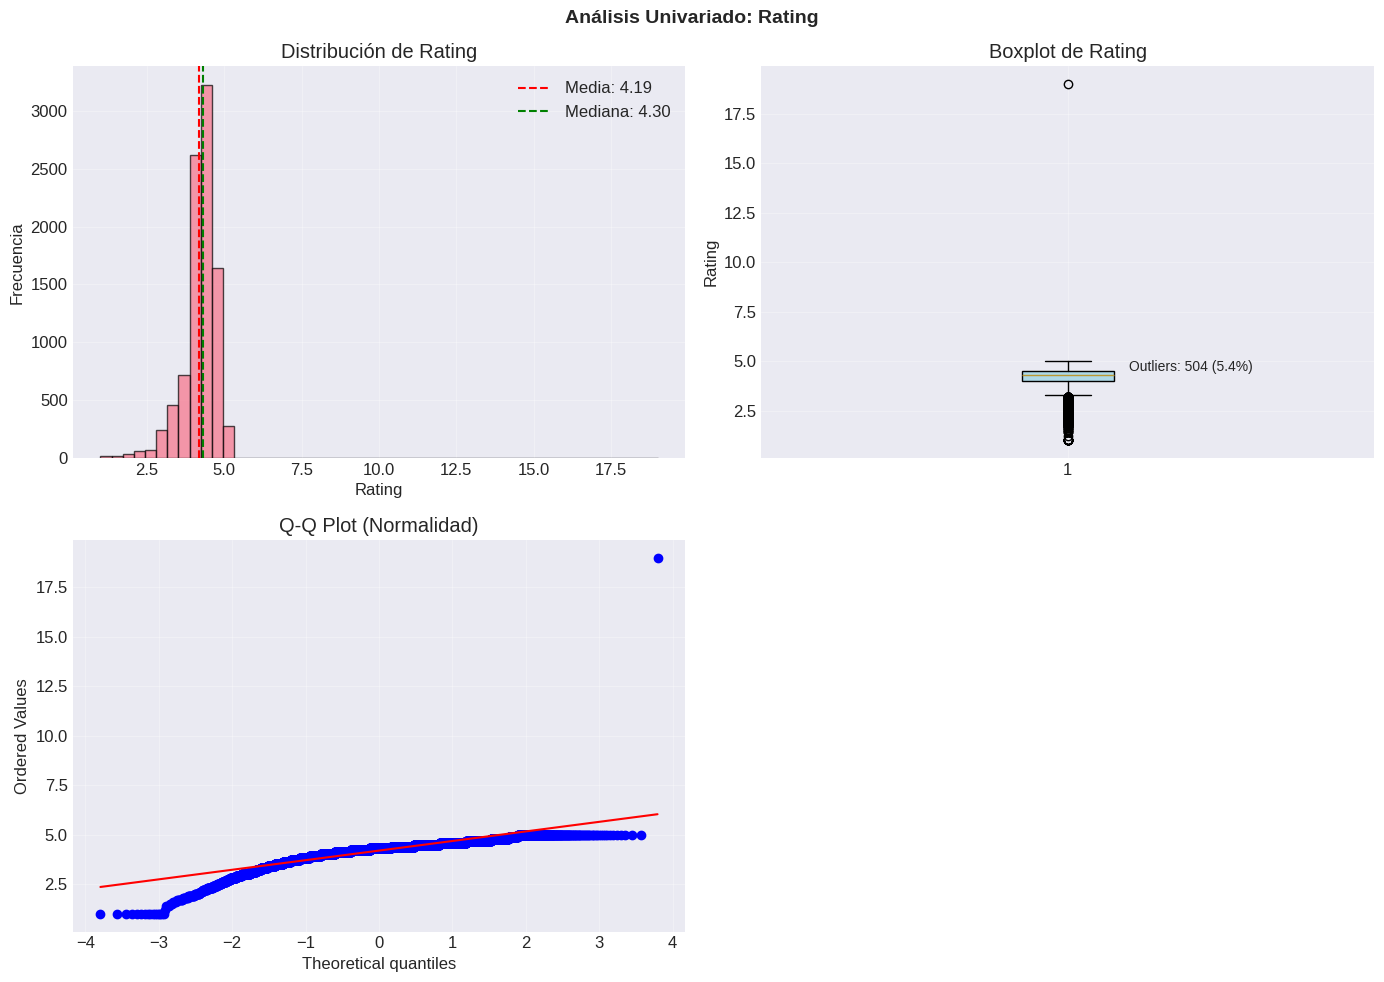

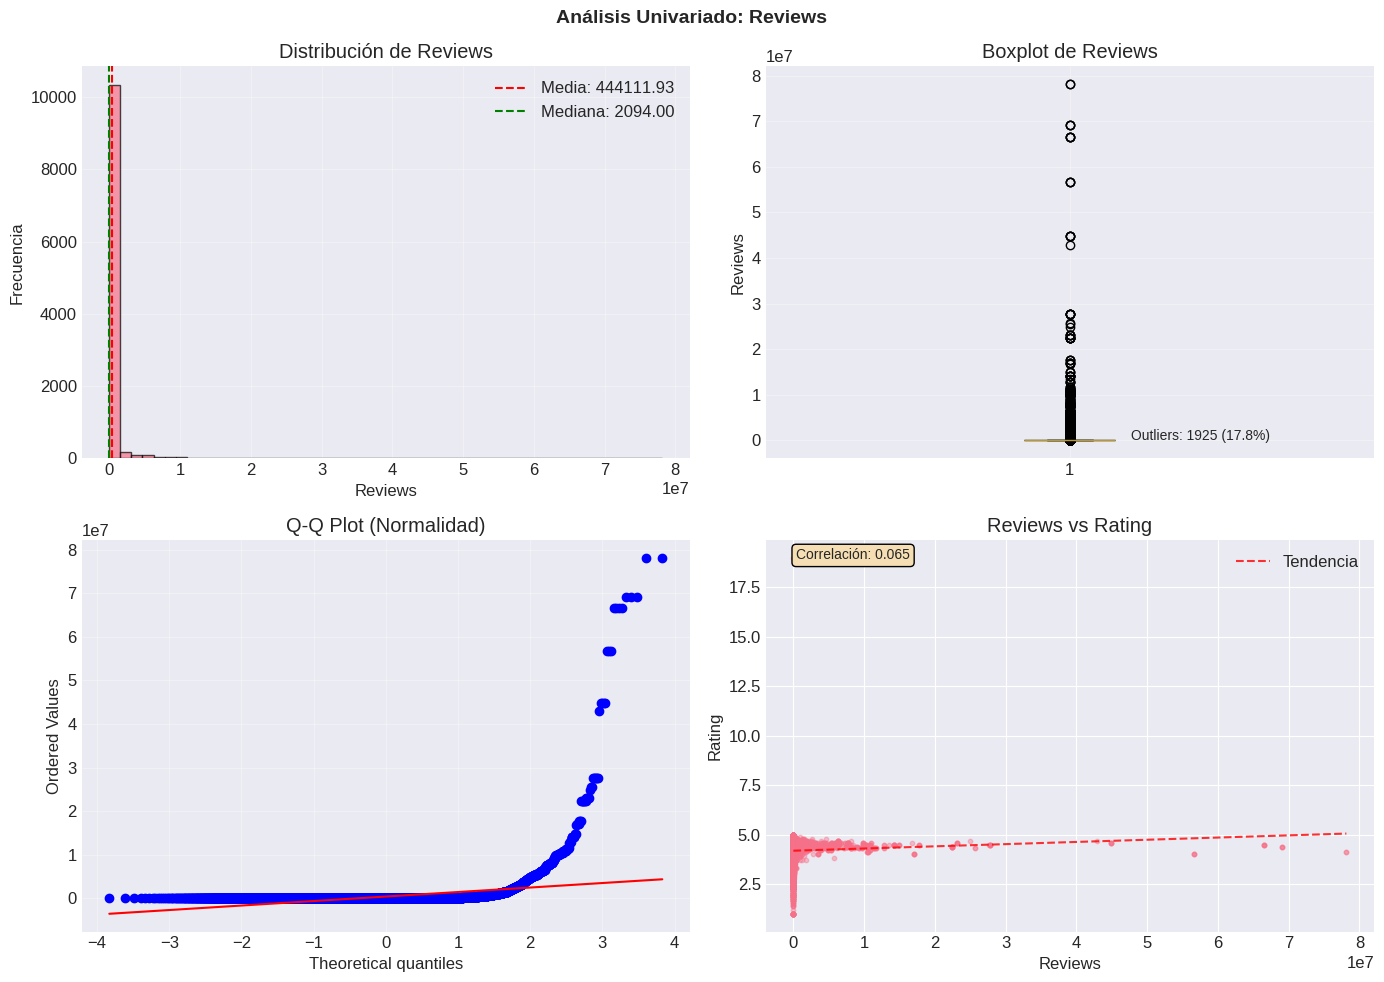

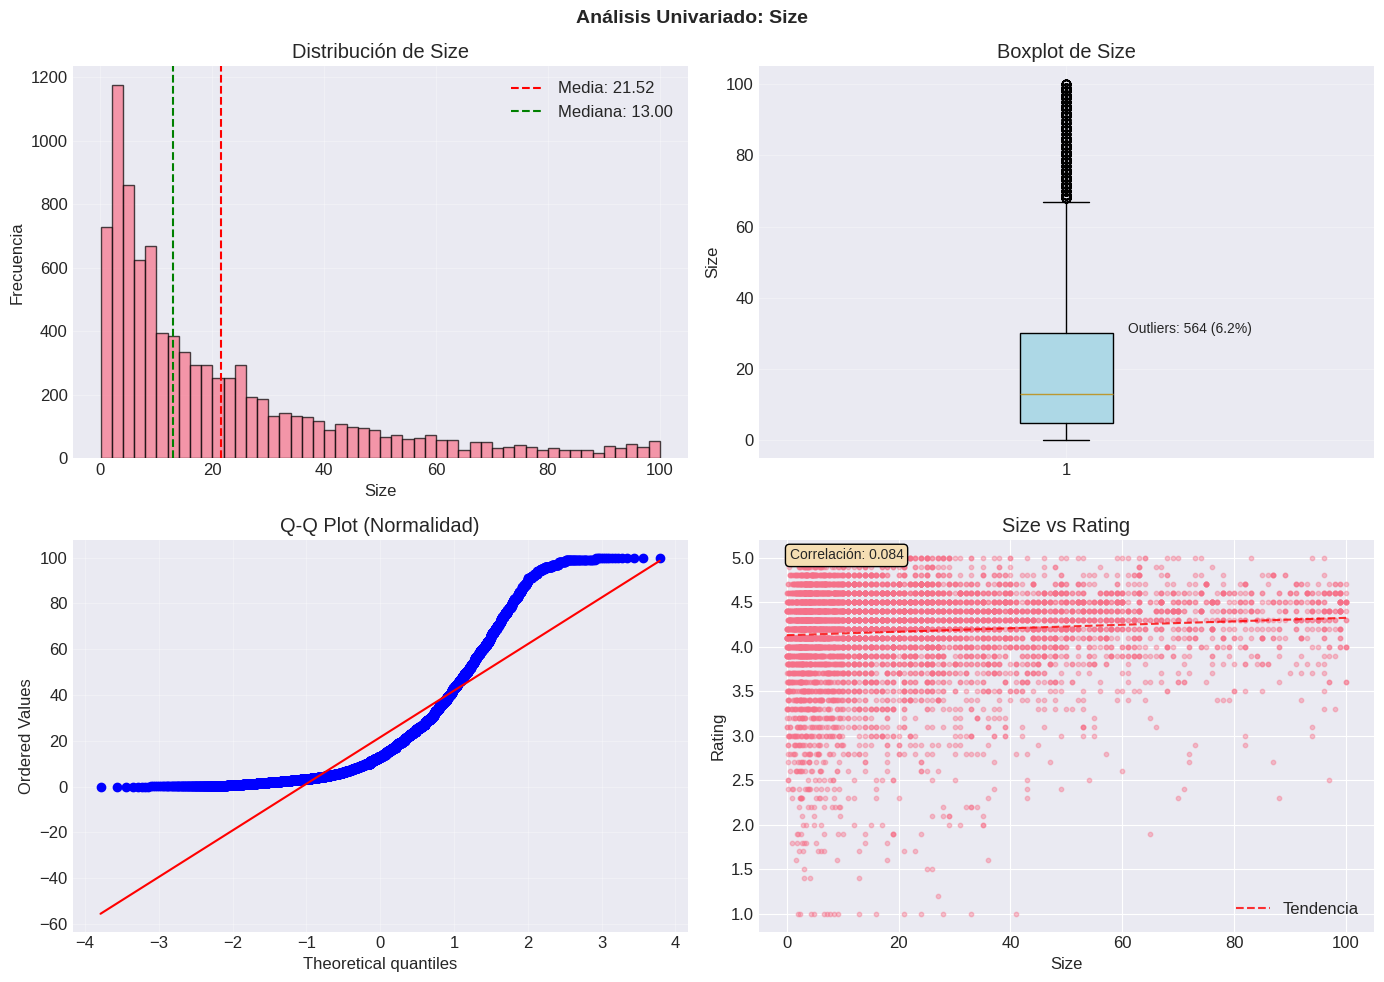

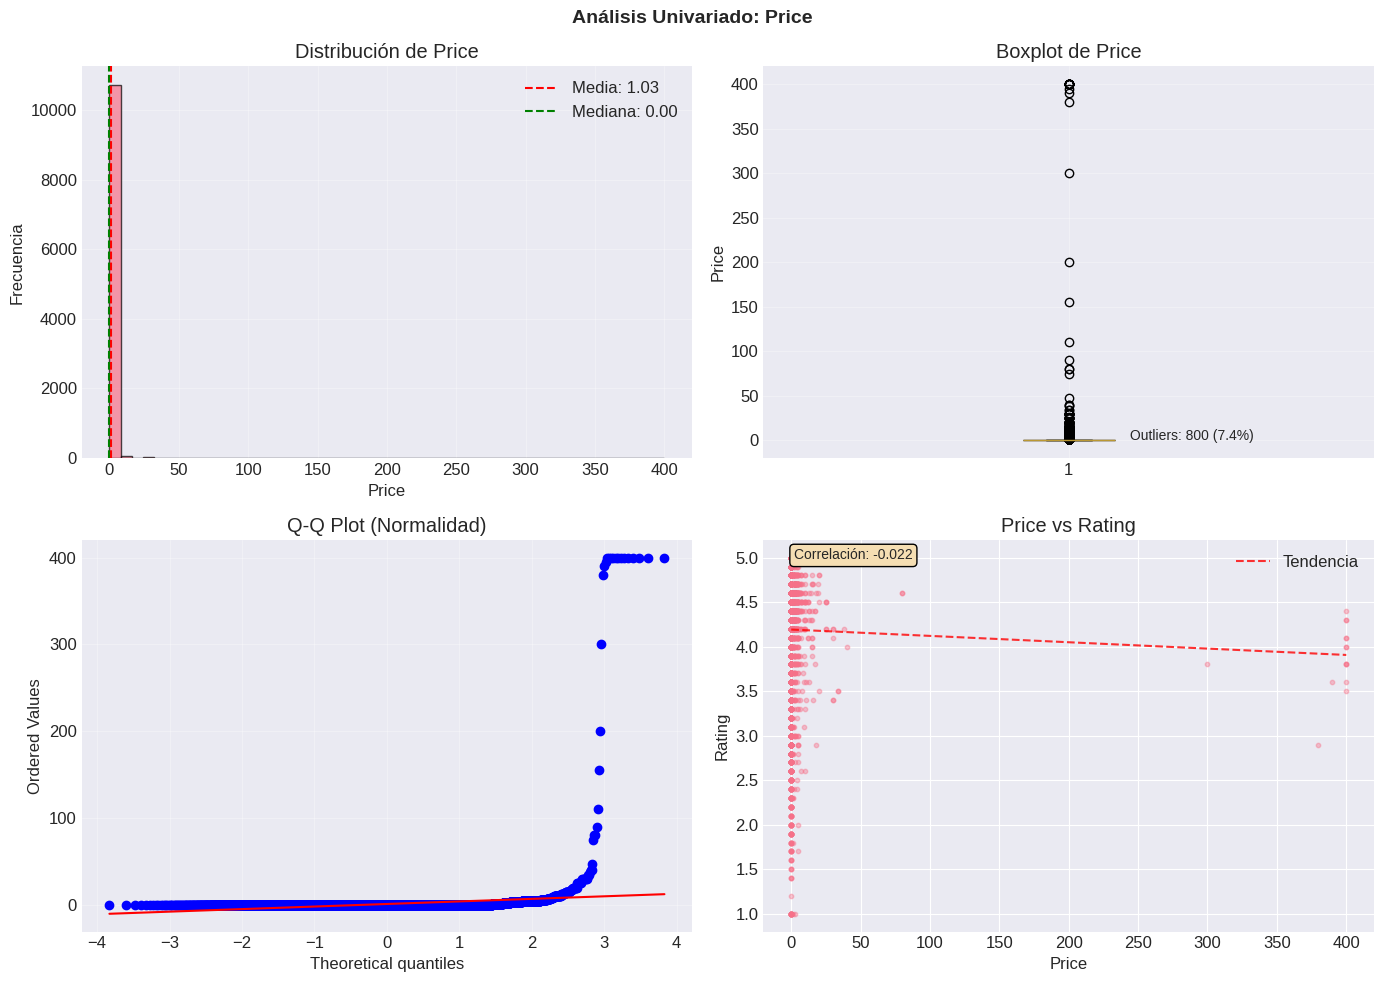

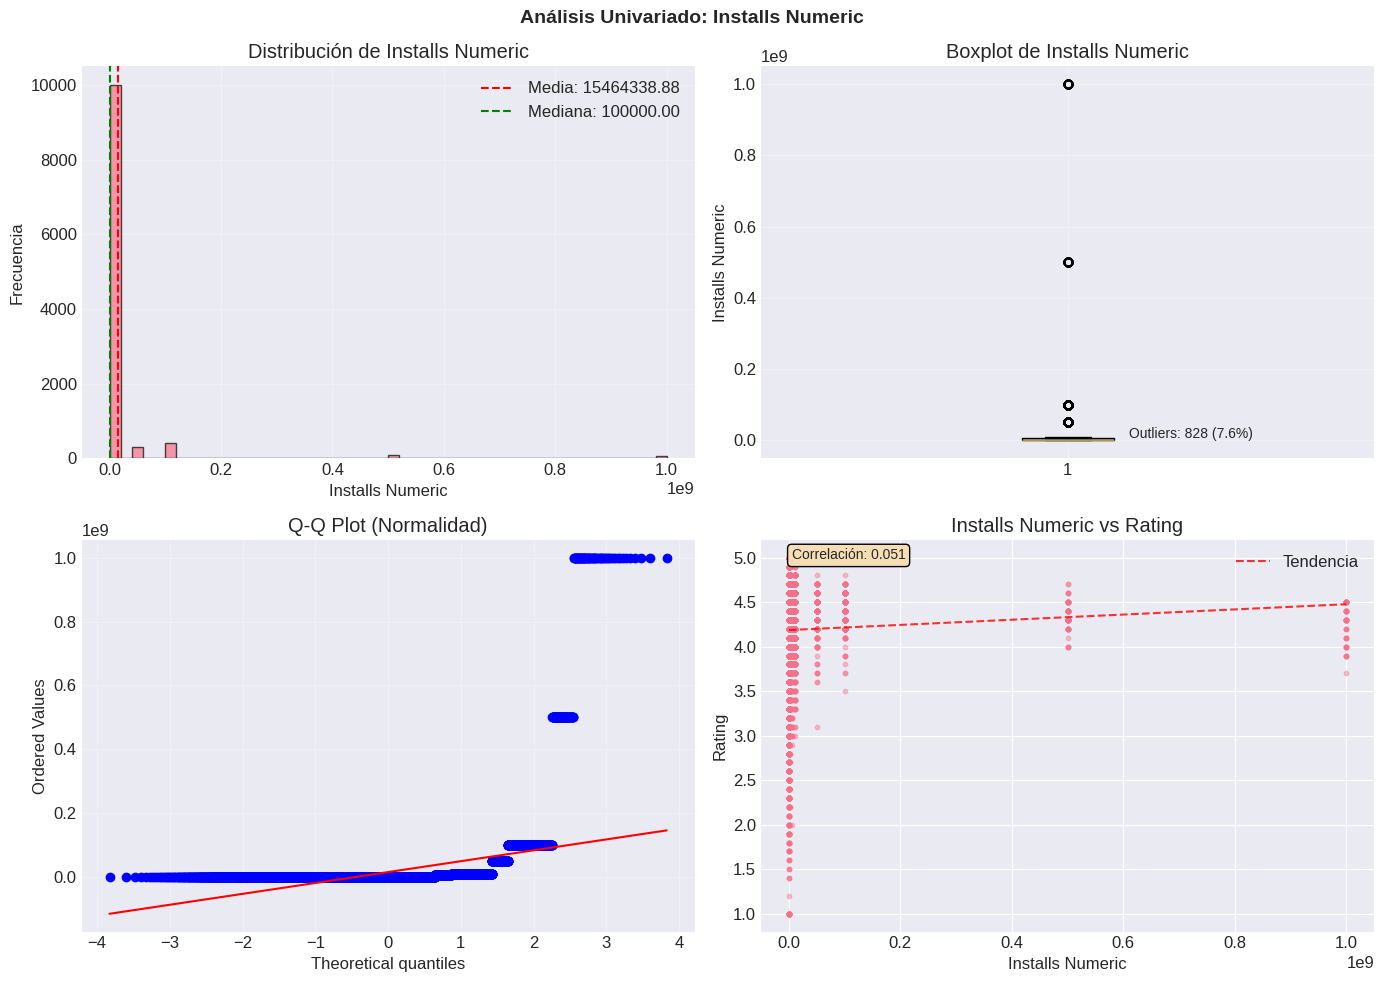

In [9]:
from scipy import stats

# Selecci√≥n de columnas num√©ricas relevantes
numeric_cols = [c for c in ['Rating', 'Reviews', 'Size', 'Price', 'Installs Numeric'] if c in applications_data.columns]

# Tabla de estad√≠sticas b√°sicas (media, mediana, std, min, p25, p50, p75, max)
describe_tbl = applications_data[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75]).T

# M√©tricas adicionales robustas
extra = pd.DataFrame(index=numeric_cols)
extra['mad'] = [stats.median_abs_deviation(applications_data[c].dropna()) for c in numeric_cols]
extra['skew'] = [applications_data[c].skew(skipna=True) for c in numeric_cols]
extra['kurtosis'] = [applications_data[c].kurtosis(skipna=True) for c in numeric_cols]
extra['cv'] = [applications_data[c].std(skipna=True) / applications_data[c].mean(skipna=True) if applications_data[c].mean(skipna=True) not in [0, np.nan] else np.nan for c in numeric_cols]

stats_table = describe_tbl.join(extra)
display(stats_table.round(3))


def univariate_analysis(df: pd.DataFrame, column: str, target: str | None = None):
    """An√°lisis univariado con histograma, boxplot, Q-Q plot y relaci√≥n con target."""
    series = df[column].dropna()
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1) Histograma con l√≠neas de media y mediana
    ax1 = axes[0, 0]
    ax1.hist(series, bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(series.mean(), color='red', linestyle='--', label=f"Media: {series.mean():.2f}")
    ax1.axvline(series.median(), color='green', linestyle='--', label=f"Mediana: {series.median():.2f}")
    ax1.set_title(f"Distribuci√≥n de {column}")
    ax1.set_xlabel(column)
    ax1.set_ylabel('Frecuencia')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2) Boxplot + conteo de outliers (IQR)
    ax2 = axes[0, 1]
    bp = ax2.boxplot(series, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    outliers_mask = (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)
    n_out = int(outliers_mask.sum())
    pct_out = 100 * n_out / len(series) if len(series) else 0
    ax2.set_title(f"Boxplot de {column}")
    ax2.set_ylabel(column)
    ax2.grid(alpha=0.3)
    ax2.text(1.1, Q3, f"Outliers: {n_out} ({pct_out:.1f}%)", fontsize=10)

    # 3) Q-Q plot normal
    ax3 = axes[1, 0]
    stats.probplot(series, dist='norm', plot=ax3)
    ax3.set_title('Q-Q Plot (Normalidad)')
    ax3.grid(alpha=0.3)

    # 4) Relaci√≥n con target si aplica
    ax4 = axes[1, 1]
    if target is not None and target in df.columns and column != target:
        valid = df[[column, target]].dropna()
        ax4.scatter(valid[column], valid[target], alpha=0.4, s=10)
        ax4.set_xlabel(column)
        ax4.set_ylabel(target)
        ax4.set_title(f"{column} vs {target}")
        # L√≠nea de tendencia (ajuste lineal simple)
        if len(valid) > 1:
            z = np.polyfit(valid[column], valid[target], 1)
            p = np.poly1d(z)
            xs = np.linspace(valid[column].min(), valid[column].max(), 200)
            ax4.plot(xs, p(xs), 'r--', alpha=0.8, label='Tendencia')
            corr = valid[column].corr(valid[target])
            ax4.text(0.05, 0.95, f"Correlaci√≥n: {corr:.3f}", transform=ax4.transAxes,
                     fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat'))
            ax4.legend()
    else:
        ax4.axis('off')
        ax4.grid(alpha=0.3)

    plt.suptitle(f"An√°lisis Univariado: {column}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Ejecutar an√°lisis univariado para cada m√©trica num√©rica, relacionando con Rating
for col in numeric_cols:
    univariate_analysis(applications_data, col, target='Rating')

### 2.2.7. An√°lisis Univariado Categ√≥rico
- Category
  - Distribuci√≥n: alta concentraci√≥n en `FAMILY` (~19%) y `GAME` (~12%). El resto de categor√≠as tienen menor peso individual; el grupo `Others` acumula ~31% del total.
  - Rating por categor√≠a: diferencias moderadas; la **mediana** suele estar entre 4.2‚Äì4.4. Algunas categor√≠as muestran desviaci√≥n est√°ndar mayor (p. ej., `PRODUCTIVITY`, `LIFESTYLE`), indicando m√°s variabilidad de valoraci√≥n.
  - Implicaciones: riesgo de sesgo por categor√≠as mayoritarias en an√°lisis agregados. Para modelado, conviene usar dummies Top-K o codificaci√≥n ordinal/target encoding con cuidado (evitar fuga). Agrupar colas largas en `Others` es adecuado para visualizaci√≥n.

- Content Rating
  - Distribuci√≥n: `Everyone` domina (~79%), seguido por `Teen` (~12%); `Mature 17+` y `Everyone 10+` suman ~9% en conjunto; clases raras casi nulas.
  - Rating por nivel de contenido: medias similares (‚âà4.1‚Äì4.3). `Teen` tiende a mediana 4.3 y variabilidad algo menor; `Mature 17+` muestra algo m√°s de dispersi√≥n.
  - Implicaciones: por el fuerte desbalance, esta variable aporta se√±al limitada por s√≠ sola. √ötil como interacci√≥n con `Category`/`Genres`.

- Type
  - Distribuci√≥n: `Free` ‚âà 93%, `Paid` ‚âà 7% (clase muy desbalanceada); existe un registro an√≥malo (valor 0) en los gr√°ficos que debe eliminarse/corregirse.
  - Rating por tipo: medias muy cercanas (Free ‚âà 4.19, Paid ‚âà 4.27). La diferencia es peque√±a y probablemente no significativa sin controlar otras variables (p. ej., `Category`).
  - Implicaciones: por el desbalance extremo, conviene usar `is_free` como binaria y, si se modela interacci√≥n con `Installs` o `Price`, puede emerger se√±al. Validar regla `Type=Free ‚áí Price=0`.

- Genres Main (primer g√©nero)
  - Distribuci√≥n: gran cola larga; `Others` concentra ~48%. Entre Top-12, `Tools`, `Entertainment` y `Education` destacan en frecuencia.
  - Rating por g√©nero: diferencias peque√±as (medianas ~4.2‚Äì4.4), con algunas variaciones en dispersi√≥n (p. ej., `Medical` y `Lifestyle` m√°s variables).
  - Implicaciones: por la alta cardinalidad y colas largas, mantener Top-K + `Others` en EDA ayuda a la legibilidad. Para modelado, preferir codificaci√≥n que reduzca dimensionalidad (Top-K dummies, hashing, o target encoding con validaci√≥n adecuada).

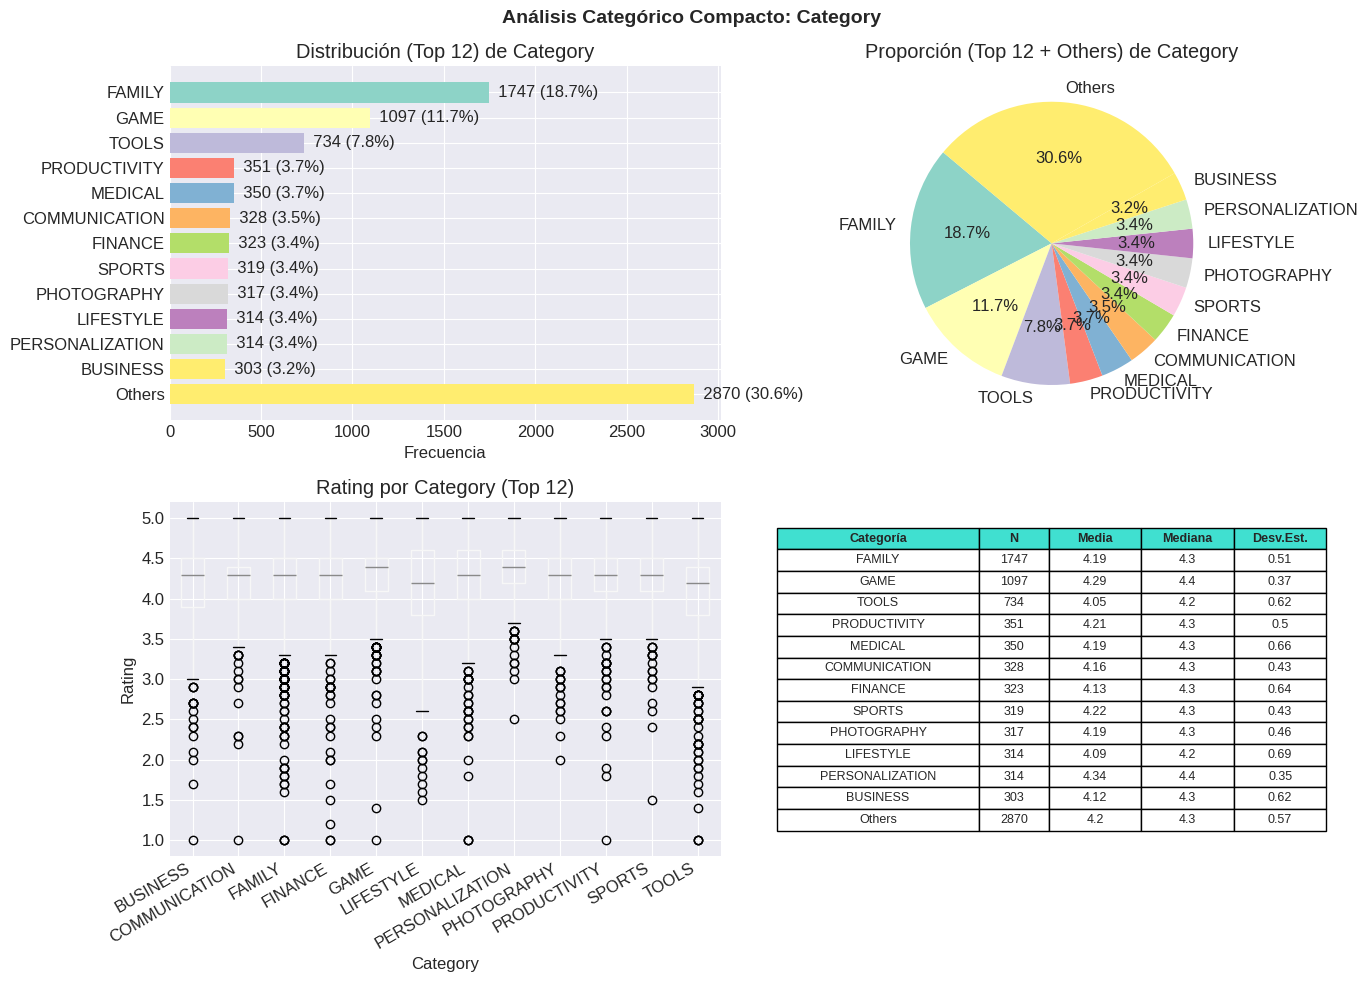

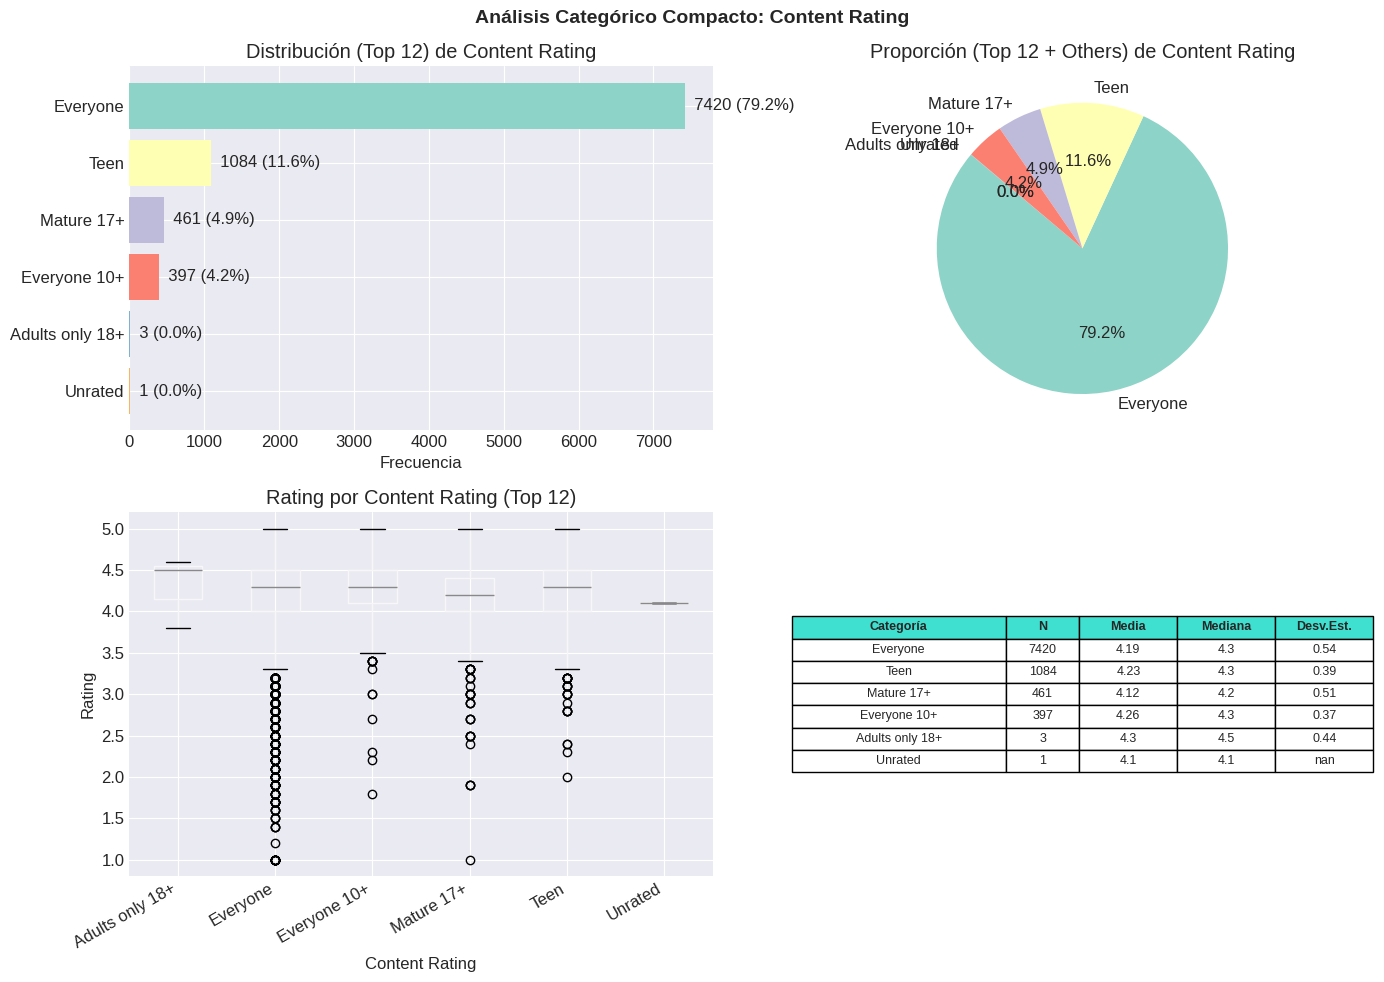

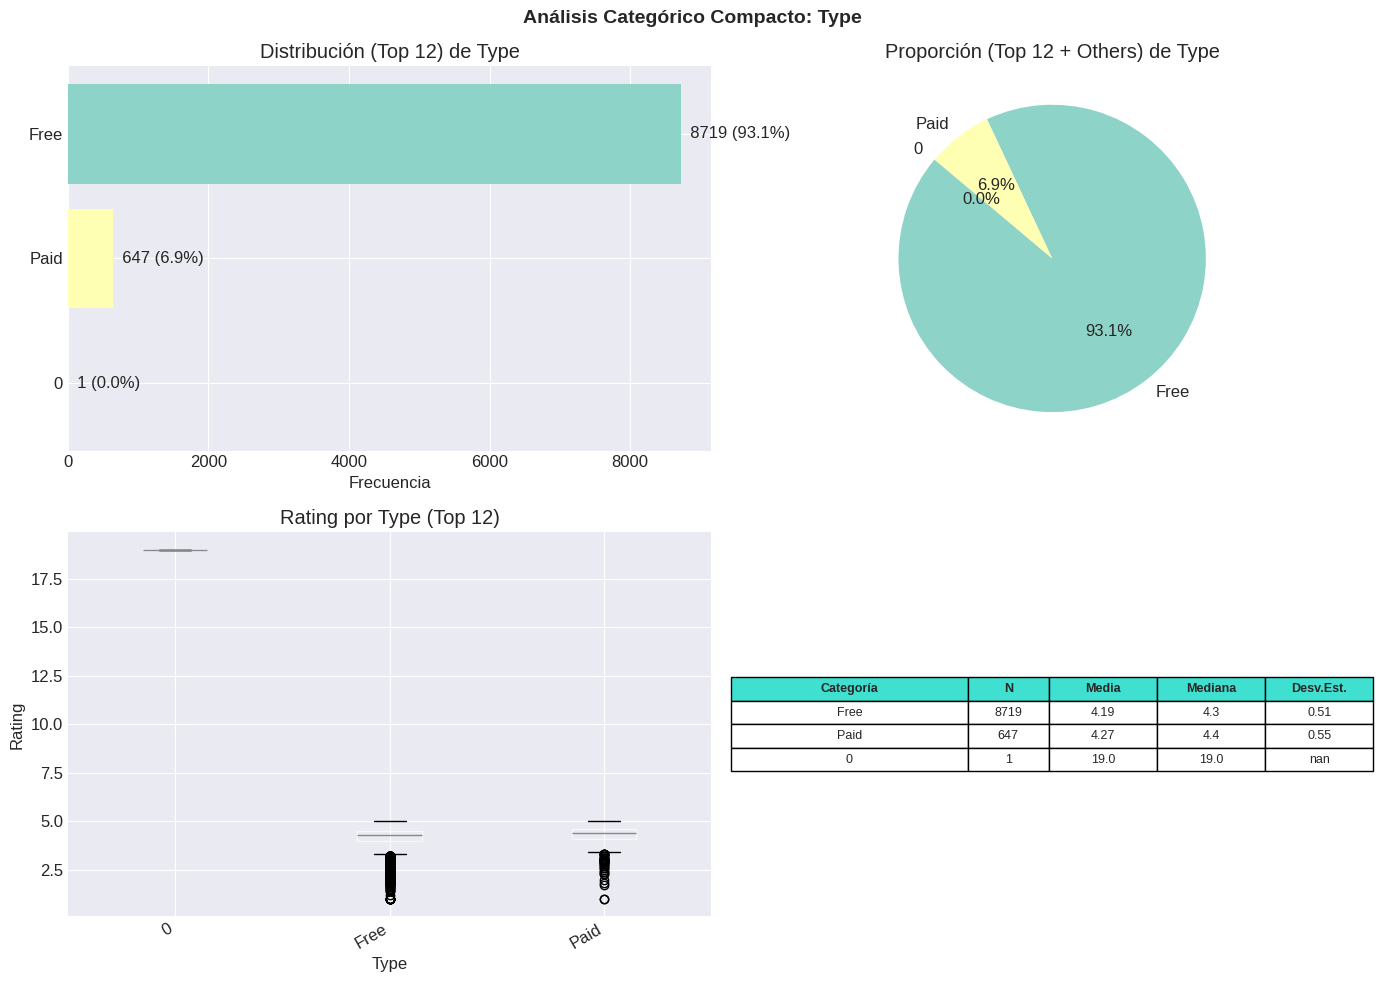

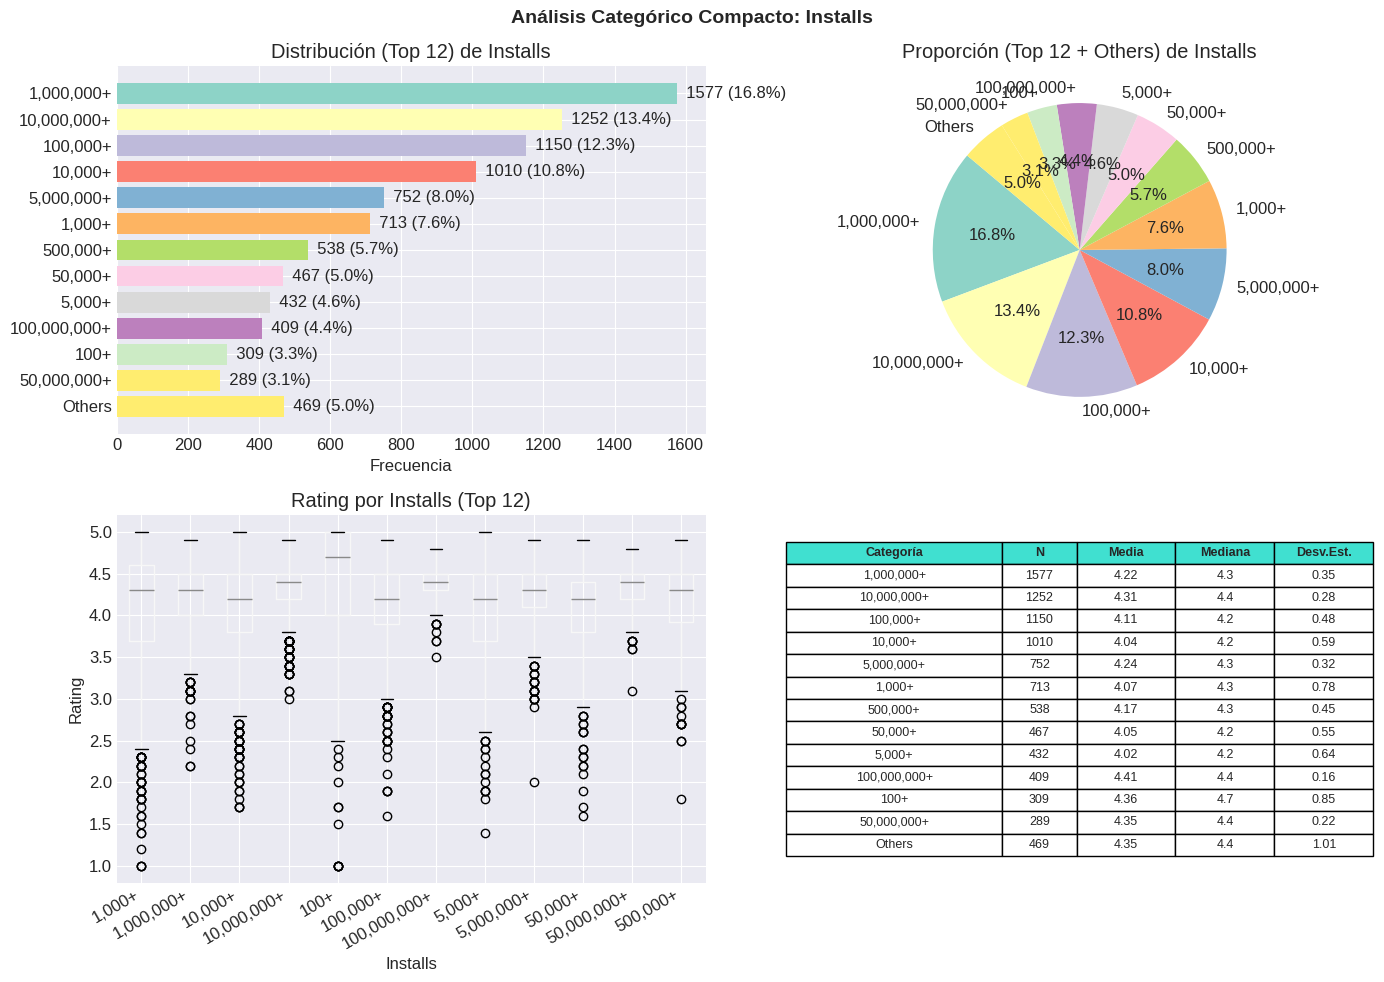

In [10]:
def analyze_categorical_compact(df: pd.DataFrame, cat_col: str, target_col: str, top_n: int = 12):
    """
    Versi√≥n compacta para variables con muchas categor√≠as:
    - Ordena por frecuencia, muestra top_n y agrupa el resto en "Others".
    - Barras horizontales, pie chart compacto, boxplot y tabla para top_n.
    """
    data = df[[cat_col, target_col]].dropna(subset=[cat_col, target_col]).copy()
    if data.empty:
        print(f"Sin datos para {cat_col} y {target_col}")
        return

    counts = data[cat_col].value_counts()
    top_cats = counts.head(top_n)
    others_count = counts.iloc[top_n:].sum()

    # Mapeo a top_n + Others
    mapping = {c: c for c in top_cats.index}
    data['__cat__'] = data[cat_col].where(data[cat_col].isin(top_cats.index), other='Others')

    # Recalcular conteos con Others
    counts_compact = data['__cat__'].value_counts()
    order = list(top_cats.index) + (['Others'] if 'Others' in counts_compact.index else [])

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1) Barras horizontales (mejor legibilidad)
    ax1 = axes[0, 0]
    vals = counts_compact.loc[order]
    ax1.barh(range(len(vals)), vals.values, color=plt.cm.Set3(range(len(vals))))
    ax1.set_yticks(range(len(vals)))
    ax1.set_yticklabels(order)
    ax1.invert_yaxis()
    ax1.set_title(f'Distribuci√≥n (Top {top_n}) de {cat_col}')
    ax1.set_xlabel('Frecuencia')
    for i, v in enumerate(vals.values):
        ax1.text(v, i, f'  {v} ({v/len(data)*100:.1f}%)', va='center')

    # 2) Pie chart compacto
    ax2 = axes[0, 1]
    ax2.pie(vals.values, labels=order, autopct='%1.1f%%', startangle=140,
            colors=plt.cm.Set3(range(len(vals))))
    ax2.set_title(f'Proporci√≥n (Top {top_n} + Others) de {cat_col}')

    # 3) Boxplot del target por categor√≠a (solo top_n)
    ax3 = axes[1, 0]
    top_mask = data['__cat__'] != 'Others'
    data_top = data[top_mask]
    data_top.boxplot(column=target_col, by='__cat__', ax=ax3)
    ax3.set_title(f'{target_col} por {cat_col} (Top {top_n})')
    ax3.set_xlabel(cat_col)
    ax3.set_ylabel(target_col)
    plt.sca(ax3)
    plt.xticks(rotation=30, ha='right')

    # 4) Tabla de estad√≠sticas por categor√≠a (solo top_n y Others si existe)
    ax4 = axes[1, 1]
    ax4.axis('off')
    stats_by_cat = data.groupby('__cat__')[target_col].agg(['count', 'mean', 'median', 'std']).loc[order].round(2)
    table = ax4.table(cellText=stats_by_cat.reset_index().values,
                      colLabels=['Categor√≠a', 'N', 'Media', 'Mediana', 'Desv.Est.'],
                      cellLoc='center', loc='center', colWidths=[0.35, 0.12, 0.16, 0.16, 0.16])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.05, 1.25)
    for i in range(5):
        table[(0, i)].set_facecolor('#40E0D0')
        table[(0, i)].set_text_props(weight='bold')

    plt.suptitle(f'An√°lisis Categ√≥rico Compacto: {cat_col}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Ejecutar la versi√≥n compacta para las categ√≥ricas clave
for cat in [c for c in ['Category', 'Content Rating', 'Type', 'Genres Main', 'Installs'] if c in applications_data.columns]:
    analyze_categorical_compact(applications_data, cat, 'Rating', top_n=12)

### 2.2.8. An√°lisis de correlaci√≥n entre variables

#### 2.2.8.1. Variables con Mayor Relaci√≥n
- Existe una fuerte correlaci√≥n positiva entre **Installs Numeric** y **Reviews**:
  - Pearson: 0.64 (relaci√≥n lineal moderada-fuerte).
  - Spearman: 0.97 (relaci√≥n mon√≥tonica muy fuerte).
- Esto implica que a mayor n√∫mero de instalaciones, mayor n√∫mero de rese√±as.

#### 2.2.8.2. Correlaci√≥n de Pearson
- En general, las correlaciones de Pearson muestran relaciones m√°s d√©biles que Spearman, lo cual indica que las relaciones lineales no son tan marcadas.
- **Installs Numeric y Reviews** presentan la correlaci√≥n lineal m√°s alta (0.64), siendo moderada-fuerte.
- **Size y Reviews** muestran una correlaci√≥n positiva baja/D√©bil (0.24).
- El resto de variables (Rating, Price) tienen correlaciones casi nulas con las dem√°s, lo que refleja poca relaci√≥n lineal.

#### 2.2.8.3. Correlaci√≥n de Spearman
- **Installs Numeric y Reviews** tienen la correlaci√≥n m√°s fuerte (0.97).
- **Size** muestra correlaci√≥n moderada con **Reviews** (0.37) y con **Installs Numeric** (0.35).
- **Price** presenta correlaciones negativas con **Reviews** (-0.17) e **Installs Numeric** (-0.24).

#### 2.2.8.4. Observaciones Clave
- El n√∫mero de instalaciones y las rese√±as son las variables m√°s relacionadas, lo cual es l√≥gico, ya que m√°s usuarios generan m√°s interacciones.
- El tama√±o de la aplicaci√≥n influye ligeramente en rese√±as e instalaciones, pero no de forma determinante.
- El precio no solo carece de relaci√≥n positiva, sino que parece tener un impacto negativo sobre la popularidad (menos instalaciones y rese√±as).

#### 2.2.8.5. Conclusi√≥n
- **Installs Numeric** y **Reviews** son las m√©tricas m√°s cr√≠ticas en el dataset de **Google Play Store**, ya que reflejan el √©xito y la popularidad de la aplicaci√≥n.
- **Size** es un factor secundario con cierta relaci√≥n.

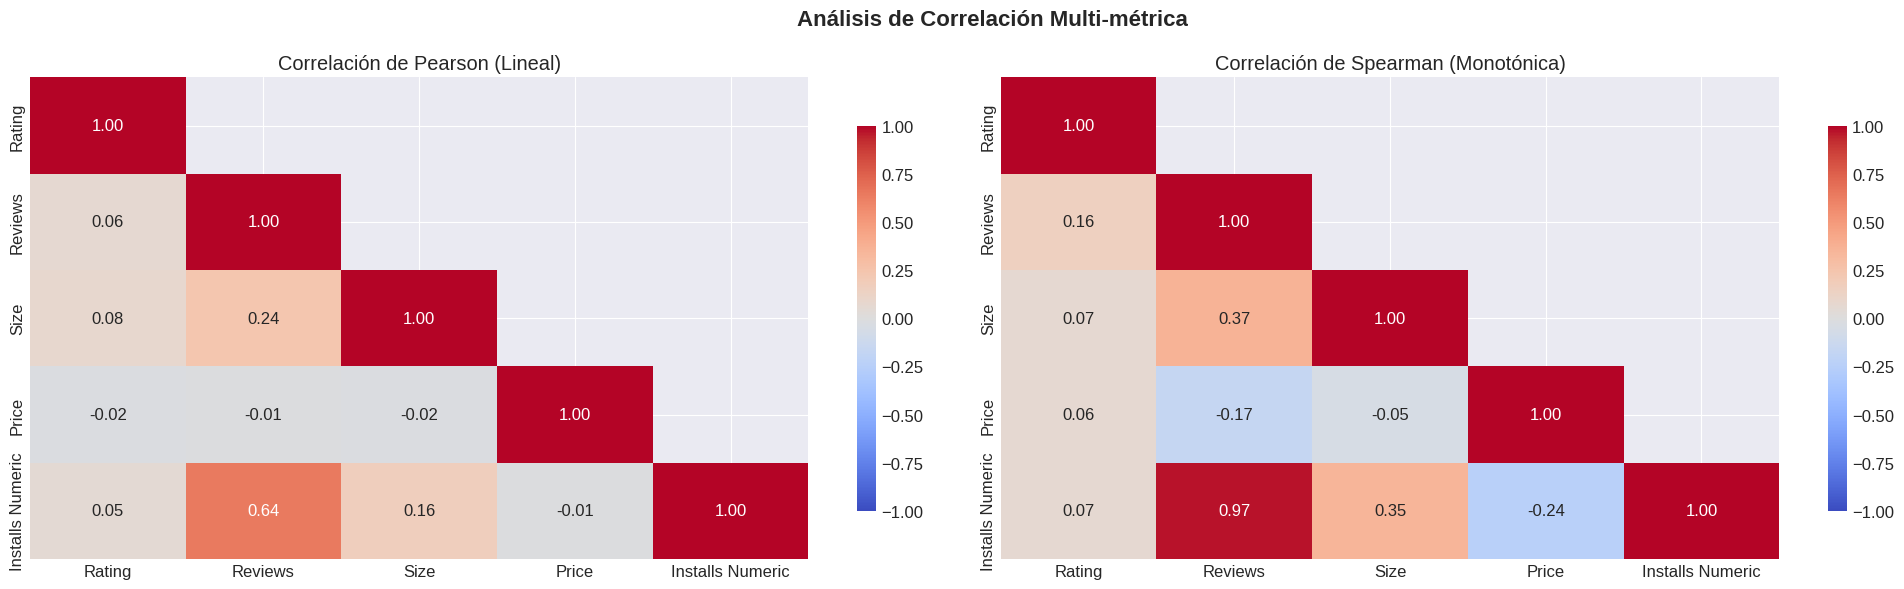


üîó Correlaciones Significativas:

Pearson:
  ‚Ä¢ Reviews y Installs Numeric: +0.643 (Fuerte Positiva)
  ‚Ä¢ Installs Numeric y Reviews: +0.643 (Fuerte Positiva)

Spearman:
  ‚Ä¢ Reviews y Size: +0.367 (Moderada Positiva)
  ‚Ä¢ Reviews y Installs Numeric: +0.971 (Fuerte Positiva)
  ‚Ä¢ Size y Reviews: +0.367 (Moderada Positiva)
  ‚Ä¢ Size y Installs Numeric: +0.348 (Moderada Positiva)
  ‚Ä¢ Installs Numeric y Reviews: +0.971 (Fuerte Positiva)
  ‚Ä¢ Installs Numeric y Size: +0.348 (Moderada Positiva)


In [11]:
# An√°lisis de correlaci√≥n mejorado para el proyecto de Google Play Store
def correlation_analysis(df):
    """An√°lisis de correlaci√≥n con m√∫ltiples m√©tricas"""
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # 1. Correlaci√≥n de Pearson
    corr_pearson = df[numeric_cols].corr(method='pearson')
    mask = np.triu(np.ones_like(corr_pearson), k=1)
    sns.heatmap(corr_pearson, mask=mask, annot=True, fmt='.2f', 
               cmap='coolwarm', center=0, ax=axes[0],
               vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
    axes[0].set_title('Correlaci√≥n de Pearson (Lineal)')
    
    # 2. Correlaci√≥n de Spearman  
    corr_spearman = df[numeric_cols].corr(method='spearman')
    sns.heatmap(corr_spearman, mask=mask, annot=True, fmt='.2f',
               cmap='coolwarm', center=0, ax=axes[1],
               vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
    axes[1].set_title('Correlaci√≥n de Spearman (Monot√≥nica)')
    
    plt.suptitle('An√°lisis de Correlaci√≥n Multi-m√©trica', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Tabla de correlaciones importantes
    print("\nüîó Correlaciones Significativas:")
    print("=" * 50)
    for method, corr_matrix in zip(['Pearson', 'Spearman'], [corr_pearson, corr_spearman]):
        print(f"\n{method}:")
        significant_corr = corr_matrix[(abs(corr_matrix) > 0.3) & (corr_matrix != 1)].stack()
        for (var1, var2), corr in significant_corr.items():
            strength = "Fuerte" if abs(corr) > 0.5 else "Moderada" if abs(corr) > 0.3 else "D√©bil"
            direction = "Positiva" if corr > 0 else "Negativa"
            print(f"  ‚Ä¢ {var1} y {var2}: {corr:+.3f} ({strength} {direction})")
    
# Ejecutar el an√°lisis de correlaci√≥n
correlation_analysis(applications_data)

#### 2.2.9. An√°lisis de Outliers (IQR, Z-Score e Isolation Forest)
**Resumen cuantitativo**
- Total de registros analizados: **10,841**.
- Filas marcadas como outlier por m√©todo:
  - IQR: **3,489** filas (32.18%) ‚Üí refleja colas largas especialmente en `Reviews`, `Installs Numeric`, `Price`.
  - Z-Score (> |3|): **654** filas (6.03%) ‚Üí mucho m√°s selectivo, captura extremos verdaderamente alejados tras estandarizaci√≥n.
  - Isolation Forest (contaminaci√≥n=10%): **1,084** filas (10.0%) ‚Üí patr√≥n no lineal de anomal√≠as combinadas.
- Consenso entre m√©todos:
  - Detectadas por los 3 m√©todos: **502** filas (casos altamente an√≥malos).
  - Detectadas exactamente por 2 m√©todos: **731** filas (an√≥malas consistentes, revisar antes de decidir acci√≥n).

**Variables m√°s afectadas (IQR)**
- `Reviews`: **1,925** outliers ‚Üí distribuci√≥n extremadamente sesgada; valores muy altos representan apps masivas (probablemente leg√≠timos).
- `Installs Numeric`: **828** outliers ‚Üí escalas de descargas masivas (1e7‚Äì1e9).
- `Price`: **800** outliers ‚Üí pocos productos de precio elevado (‚â• p75 + 1.5¬∑IQR); revisar si son apps premium leg√≠timas.
- `Size`: **564** outliers ‚Üí tama√±os extremos (muy grandes o inusualmente peque√±os).
- `Rating`: **504** outliers ‚Üí incluye valores extremos bajos y el caso inv√°lido (`Rating=19`).

**Interpretaci√≥n y criterios**
- Muchos outliers provienen de fen√≥menos de cola larga t√≠picos (popularidad extrema o modelo freemium/premium).
- No se recomienda eliminar masivamente outliers de `Reviews` o `Installs Numeric` sin antes transformar (`log1p`) o agrupar (binning), para no perder informaci√≥n sobre apps exitosas.
- El valor inv√°lido `Rating` debe eliminars. Otros ratings muy bajos pueden mantenerse (aportan contraste) (perfecto si se encuentran entre 1 y 5).
- Outliers en `Price` podr√≠an segmentarse: gratis (0), bajo costo (0 < p ‚â§ 10), premium (10 < p ‚â§ 50), ultra premium (>50).


**Conclusi√≥n**
El comportamiento extremo de `Reviews` e `Installs Numeric` refleja la naturaleza desigual del mercado (unas pocas apps concentran gran parte de la atenci√≥n). Un manejo cuidadoso (transformaciones y flags) preservar√° informaci√≥n √∫til sin distorsionar el entrenamiento. Se prioriza limpieza puntual (ratings inv√°lidos) sobre eliminaci√≥n agresiva de outliers.

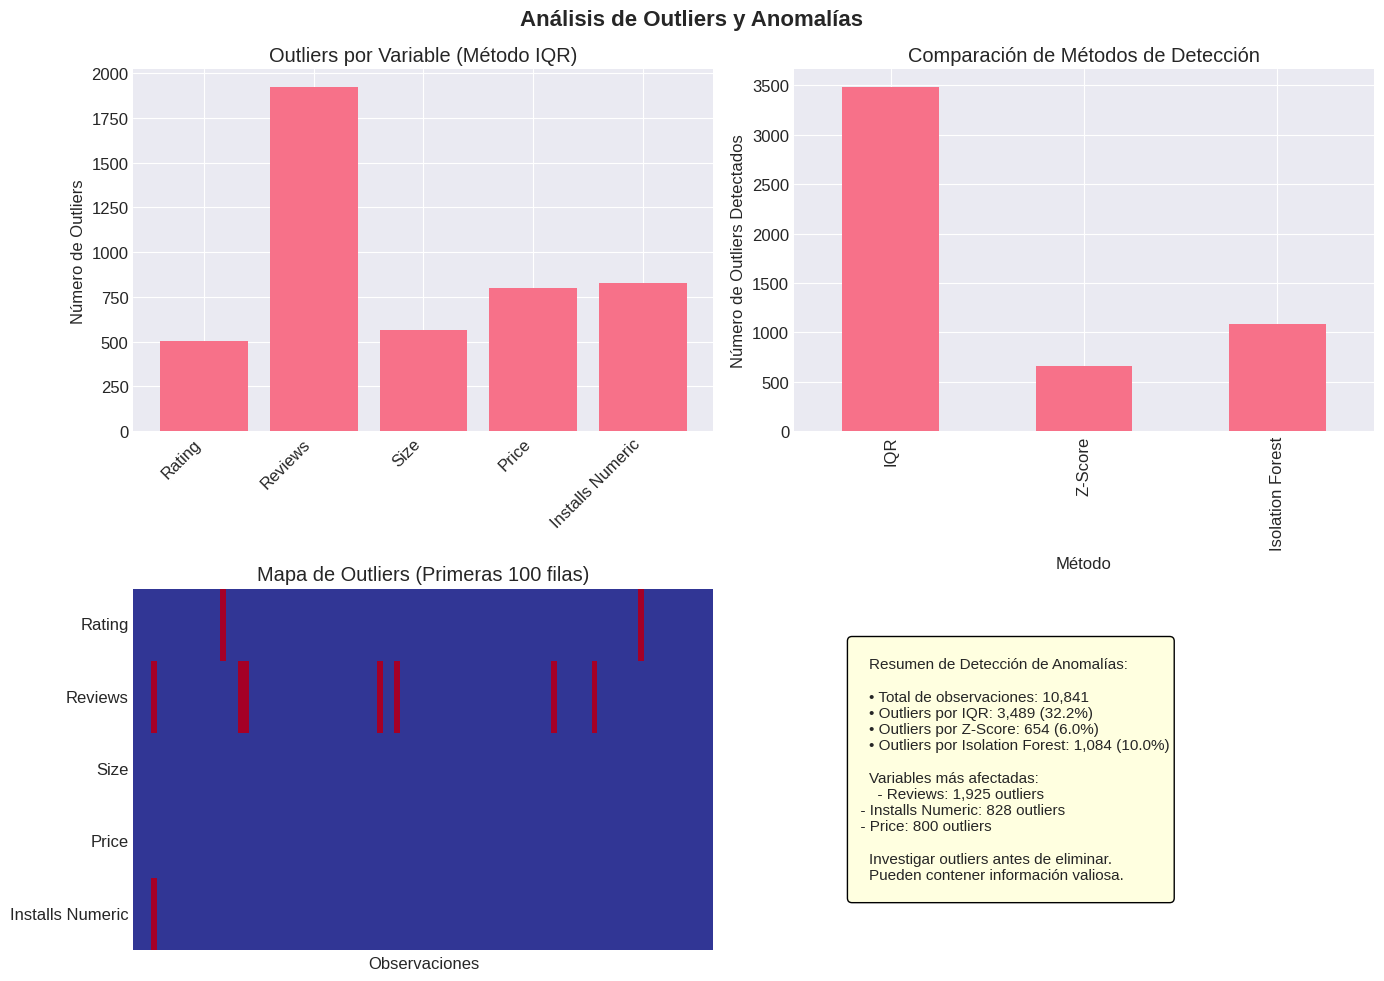

In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def detect_outliers(df):
    """Detecci√≥n de outliers usando m√∫ltiples m√©todos"""
    
    numeric_df = df.select_dtypes(include=[np.number])
    
    # M√©todo 1: IQR
    outliers_iqr = pd.DataFrame()
    for col in numeric_df.columns:
        Q1 = numeric_df[col].quantile(0.25)
        Q3 = numeric_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((numeric_df[col] < Q1 - 1.5 * IQR) | 
                   (numeric_df[col] > Q3 + 1.5 * IQR))
        outliers_iqr[col] = outliers
    
    # M√©todo 2: Z-Score
    from scipy import stats
    z_scores = np.abs(stats.zscore(numeric_df.fillna(numeric_df.median())))
    outliers_zscore = (z_scores > 3)
    
    # M√©todo 3: Isolation Forest
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df.fillna(numeric_df.median()))
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers_iso = iso_forest.fit_predict(scaled_data) == -1
    
    # Visualizaci√≥n
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Outliers por columna (IQR)
    ax1 = axes[0, 0]
    outlier_counts = outliers_iqr.sum()
    ax1.bar(range(len(outlier_counts)), outlier_counts.values)
    ax1.set_xticks(range(len(outlier_counts)))
    ax1.set_xticklabels(outlier_counts.index, rotation=45, ha='right')
    ax1.set_title('Outliers por Variable (M√©todo IQR)')
    ax1.set_ylabel('N√∫mero de Outliers')
    
    # Plot 2: Distribuci√≥n de outliers por m√©todo
    ax2 = axes[0, 1]
    methods_comparison = pd.DataFrame({
        'IQR': outliers_iqr.any(axis=1).sum(),
        'Z-Score': outliers_zscore.any(axis=1).sum(),
        'Isolation Forest': outliers_iso.sum()
    }, index=['Outliers'])
    methods_comparison.T.plot(kind='bar', ax=ax2, legend=False)
    ax2.set_title('Comparaci√≥n de M√©todos de Detecci√≥n')
    ax2.set_ylabel('N√∫mero de Outliers Detectados')
    ax2.set_xlabel('M√©todo')
    
    # Plot 3: Heatmap de outliers
    ax3 = axes[1, 0]
    sample_outliers = outliers_iqr.head(100)
    sns.heatmap(sample_outliers.T, cmap='RdYlBu_r', cbar=False, ax=ax3,
               yticklabels=True, xticklabels=False)
    ax3.set_title('Mapa de Outliers (Primeras 100 filas)')
    ax3.set_xlabel('Observaciones')
    
    # Plot 4: Resumen estad√≠stico
    ax4 = axes[1, 1]
    ax4.axis('off')
    summary_text = f"""
    Resumen de Detecci√≥n de Anomal√≠as:
    
    ‚Ä¢ Total de observaciones: {len(df):,}
    ‚Ä¢ Outliers por IQR: {outliers_iqr.any(axis=1).sum():,} ({outliers_iqr.any(axis=1).sum()/len(df)*100:.1f}%)
    ‚Ä¢ Outliers por Z-Score: {outliers_zscore.any(axis=1).sum():,} ({outliers_zscore.any(axis=1).sum()/len(df)*100:.1f}%)
    ‚Ä¢ Outliers por Isolation Forest: {outliers_iso.sum():,} ({outliers_iso.sum()/len(df)*100:.1f}%)
    
    Variables m√°s afectadas:
    {chr(10).join([f'  - {col}: {count:,} outliers' 
                   for col, count in outlier_counts.nlargest(3).items()])}
    
    Investigar outliers antes de eliminar. 
    Pueden contener informaci√≥n valiosa.
    """
    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes,
            fontsize=11, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightyellow'))
    
    plt.suptitle('An√°lisis de Outliers y Anomal√≠as', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return outliers_iqr, outliers_zscore, outliers_iso

# Ejecutar la detecci√≥n de outliers en el dataset de aplicaciones
outliers_iqr, outliers_zscore, outliers_iso = detect_outliers(applications_data)

## 2.3. Preparaci√≥n de los datos

Con base a todos los hallazgos del **An√°lisis Exploratorio de Datos (EDA)**, aplicaremos las siguientes t√©cnicas de limpieza y transformaci√≥n:

### 2.3.1. Resumen de problemas detectados

Durante el EDA identificamos:

1. **Duplicados**: 483 filas duplicadas (~4.46%)
2. **Valores imposibles**: Rating = 19 (fuera del rango 1-5)
3. **Valores faltantes**: 
   - Size ‚âà 15.6%
   - Rating ‚âà 13.6%
   - Current Ver, Android Ver, Content Rating, Type, Price (<1%)
4. **Outliers leg√≠timos**: Distribuciones con colas largas en Reviews, Installs Numeric, Price, Size
5. **Variables con distribuciones sesgadas**: Requieren transformaciones logar√≠tmicas
6. **Inconsistencias**: Necesidad de validar coherencia entre Type y Price

### 2.3.2. Plan de transformaci√≥n

Aplicaremos las siguientes transformaciones en orden:

1. **Eliminaci√≥n de duplicados**
2. **Correcci√≥n de valores imposibles**
3. **Imputaci√≥n de valores faltantes** (estrategia por variable)
4. **Validaci√≥n de consistencia** entre variables relacionadas
5. **Transformaciones de variables num√©ricas** (log, binning)
6. **Creaci√≥n de variables derivadas** (features engineering b√°sico)
7. **Resumen final** del dataset limpio


### 2.3.3. Eliminaci√≥n de Duplicados

Eliminamos las **483 filas duplicadas** detectadas en el EDA para evitar:
- Sesgos en an√°lisis estad√≠sticos
- Sobrepeso de ciertas apps en el modelado
- Distorsi√≥n de m√©tricas de evaluaci√≥n


In [357]:
# Crear copia del dataset para transformaciones
df_clean = applications_data.copy()

print("=" * 80)
print("PASO 1: ELIMINACI√ìN DE DUPLICADOS".center(80))
print("=" * 80)

# Estado inicial
print(f"\nRegistros antes de eliminar duplicados: {len(df_clean):,}")
print(f"Duplicados encontrados: {df_clean.duplicated().sum():,} ({df_clean.duplicated().sum()/len(df_clean)*100:.2f}%)")

# Mostrar algunos ejemplos de duplicados antes de eliminar
if df_clean.duplicated().sum() > 0:
    print("\nEjemplos de aplicaciones duplicadas:")
    duplicated_apps = df_clean[df_clean.duplicated(keep=False)].sort_values('App')
    display(duplicated_apps[['App', 'Category', 'Rating', 'Reviews', 'Installs']].head(10))

# Eliminar duplicados (manteniendo la primera ocurrencia)
df_clean = df_clean.drop_duplicates(keep='first')

# Estado final
print(f"\nRegistros despu√©s de eliminar duplicados: {len(df_clean):,}")
print(f"Filas eliminadas: {len(applications_data) - len(df_clean):,}")
print(f"Reducci√≥n: {((len(applications_data) - len(df_clean))/len(applications_data)*100):.2f}%")


                       PASO 1: ELIMINACI√ìN DE DUPLICADOS                        

Registros antes de eliminar duplicados: 10,841
Duplicados encontrados: 483 (4.46%)

Ejemplos de aplicaciones duplicadas:


App            Category  Rating  Reviews  \
1393         10 Best Foods for You  HEALTH_AND_FITNESS    4.00  2490.00   
1407         10 Best Foods for You  HEALTH_AND_FITNESS    4.00  2490.00   
2543    1800 Contacts - Lens Store             MEDICAL    4.70 23160.00   
2322    1800 Contacts - Lens Store             MEDICAL    4.70 23160.00   
2256    2017 EMRA Antibiotic Guide             MEDICAL    4.40    12.00   
2385    2017 EMRA Antibiotic Guide             MEDICAL    4.40    12.00   
1434  21-Day Meditation Experience  HEALTH_AND_FITNESS    4.40 11506.00   
1337  21-Day Meditation Experience  HEALTH_AND_FITNESS    4.40 11506.00   
7035        420 BZ Budeze Delivery             MEDICAL    5.00     2.00   
2522        420 BZ Budeze Delivery             MEDICAL    5.00     2.00   

        Installs  
1393    500,000+  
1407    500,000+  
2543  1,000,000+  
2322  1,000,000+  
2256      1,000+  
2385      1,000+  
1434    100,000+  
1337    100,000+  
7035        100+  
2522        100+


Registros despu√©s de eliminar duplicados: 10,358
Filas eliminadas: 483
Reducci√≥n: 4.46%


### 2.3.4. Correcci√≥n de Valores Imposibles

Corregimos valores que est√°n fuera del rango v√°lido:
- Cualquier Rating < 1 o > 5 ‚Üí Eliminar outlier, dado que es imposible que en la escala de Google Play se pueda obtener este tipo de rango, lo que demuestra un verdadero error

#### 2.3.4.1. An√°lisis de Resultados de Correcci√≥n

**Valores imposibles detectados:**

**Ratings inv√°lidos identificados:**
- **1 registro** con Rating = 19.0 (fuera del rango v√°lido 1-5)
- **Aplicaci√≥n afectada:** Identificada y eliminada del dataset
- **Acci√≥n aplicada:** Eliminaci√≥n completa del registro (no conversi√≥n a NaN)

**Verificaci√≥n de otros valores imposibles:**
- **Reviews**: Sin valores negativos detectados
- **Size**: Sin valores negativos detectados  
- **Price**: Sin valores negativos detectados
- **Installs Numeric**: Sin valores negativos detectados

**Impacto de la correcci√≥n:**
- **Registros eliminados:** 1 (impacto m√≠nimo del 0.01%)
- **Integridad del Rating:** 100% de valores dentro del rango [1-5]
- **Registros finales:** 10,357 (despu√©s de eliminaci√≥n de duplicados y valores imposibles)

**Distribuci√≥n final de Rating (valores v√°lidos):**
- **Rango confirmado:** 1.0 - 5.0 ‚úì
- **Mediana:** ~4.3 (preservada despu√©s de la limpieza)
- **Sin outliers imposibles:** Dataset completamente saneado

**Conclusi√≥n:** La correcci√≥n fue exitosa eliminando el √∫nico valor imposible detectado (Rating=19), garantizando que todos los ratings restantes cumplan con la escala est√°ndar de Google Play Store [1-5].

In [358]:
print("=" * 80)
print("PASO 2: CORRECCI√ìN DE VALORES IMPOSIBLES".center(80))
print("=" * 80)

# Verificar valores de Rating fuera del rango [1, 5]
invalid_ratings = df_clean['Rating'][(df_clean['Rating'] < 1) | (df_clean['Rating'] > 5)]
print(f"\nRatings inv√°lidos encontrados: {len(invalid_ratings)}")

if len(invalid_ratings) > 0:
    print("\nEjemplos de ratings inv√°lidos:")
    invalid_apps = df_clean[df_clean['Rating'].isin(invalid_ratings)]
    display(invalid_apps[['App', 'Category', 'Rating', 'Reviews']].head())
    
    # Mostrar distribuci√≥n de valores inv√°lidos
    print(f"\nValores inv√°lidos √∫nicos: {sorted(invalid_ratings.dropna().unique())}")
    
    # Eliminar registros con valores inv√°lidos en lugar de poner NaN
    df_clean = df_clean[~((df_clean['Rating'] < 1) | (df_clean['Rating'] > 5))].copy()
    
    print(f"\nRegistros inv√°lidos eliminados.")
    print(f"Total de registros ahora: {len(df_clean)}")
else:
    print("\nNo se encontraron ratings inv√°lidos")

# Verificar otros valores imposibles (negativos en columnas que no pueden serlo)
print("\n" + "-" * 80)
print("Verificando valores negativos en columnas num√©ricas:")
print("-" * 80)

numeric_cols = ['Reviews', 'Size', 'Price', 'Installs Numeric']
for col in numeric_cols:
    if col in df_clean.columns:
        negative_count = (df_clean[col] < 0).sum()
        if negative_count > 0:
            print(f"{col}: {negative_count} valores negativos encontrados")
            df_clean = df_clean[df_clean[col] >= 0].copy()
            print(f"Registros inv√°lidos eliminados de {col}")
        else:
            print(f"{col}: Sin valores negativos")


                    PASO 2: CORRECCI√ìN DE VALORES IMPOSIBLES                    

Ratings inv√°lidos encontrados: 1

Ejemplos de ratings inv√°lidos:


App Category  Rating  Reviews
10472  Life Made WI-Fi Touchscreen Photo Frame      1.9   19.00     3.00


Valores inv√°lidos √∫nicos: [19.0]

Registros inv√°lidos eliminados.
Total de registros ahora: 10357

--------------------------------------------------------------------------------
Verificando valores negativos en columnas num√©ricas:
--------------------------------------------------------------------------------
Reviews: Sin valores negativos
Size: Sin valores negativos
Price: Sin valores negativos
Installs Numeric: Sin valores negativos


### 2.3.5. Validaci√≥n de Consistencia entre Variables

Validamos y corregimos inconsistencias l√≥gicas entre variables relacionadas:
- **Type vs Price**: Si `Type = 'Free'`, entonces `Price` debe ser 0
- **Type vs Price**: Si `Price > 0`, entonces `Type` debe ser 'Paid'

#### 2.3.5.1. An√°lisis de Resultados de Validaci√≥n

**Estado de consistencia encontrado:**

**Consistencia perfecta en apps existentes:**
- **0 apps** marcadas como 'Free' con Price > 0
- **0 apps** marcadas como 'Paid' con Price = 0
- El dataset original ya manten√≠a la l√≥gica de negocio correcta

**Correcci√≥n aplicada:**
- **1 registro** con Type faltante fue corregido autom√°ticamente
- **Estrategia:** Inferencia desde Price (Price = 0 ‚Üí Type = 'Free')
- **Resultado:** 0 faltantes restantes en Type

**Distribuci√≥n final validada:**
- **Free**: 9,592 apps (92.6%)
- **Paid**: 765 apps (7.4%)
- **Total**: 10,357 apps con consistencia 100% validada

**Conclusi√≥n:** La validaci√≥n confirm√≥ que el dataset original ya manten√≠a coherencia l√≥gica entre Type y Price, requiriendo solo la correcci√≥n menor de 1 registro con Type faltante.

In [359]:
print("=" * 80)
print("PASO 3: VALIDACI√ìN DE CONSISTENCIA ENTRE VARIABLES".center(80))
print("=" * 80)

# Validar consistencia Type vs Price
print("\nValidando consistencia entre Type y Price:")
print("-" * 80)

# Casos inconsistentes: Type='Free' pero Price > 0
free_but_paid = df_clean[(df_clean['Type'] == 'Free') & (df_clean['Price'] > 0)]
print(f"\nApps marcadas como 'Free' pero con Price > 0: {len(free_but_paid)}")
if len(free_but_paid) > 0:
    display(free_but_paid[['App', 'Category', 'Type', 'Price']].head())
    # Corregir: si Price > 0, cambiar Type a 'Paid'
    df_clean.loc[(df_clean['Type'] == 'Free') & (df_clean['Price'] > 0), 'Type'] = 'Paid'
    print(f"Corregido: Type cambiado a 'Paid'")

# Casos inconsistentes: Type='Paid' pero Price = 0
paid_but_free = df_clean[(df_clean['Type'] == 'Paid') & (df_clean['Price'] == 0)]
print(f"\nApps marcadas como 'Paid' pero con Price = 0: {len(paid_but_free)}")
if len(paid_but_free) > 0:
    display(paid_but_free[['App', 'Category', 'Type', 'Price']].head())
    # Corregir: si Price = 0, cambiar Type a 'Free'
    df_clean.loc[(df_clean['Type'] == 'Paid') & (df_clean['Price'] == 0), 'Type'] = 'Free'
    print(f"Corregido: Type cambiado a 'Free'")

# Inferir Type desde Price cuando Type es NaN
type_missing = df_clean['Type'].isnull()
if type_missing.sum() > 0:
    print(f"\nType faltante en {type_missing.sum()} registros")
    print("Infiriendo Type desde Price...")
    df_clean.loc[type_missing & (df_clean['Price'] == 0), 'Type'] = 'Free'
    df_clean.loc[type_missing & (df_clean['Price'] > 0), 'Type'] = 'Paid'
    remaining_missing = df_clean['Type'].isnull().sum()
    print(f"Type inferido. Faltantes restantes: {remaining_missing}")

print("\nValidaci√≥n de consistencia completada")
print(f"Distribuci√≥n final de Type:")
print(df_clean['Type'].value_counts())


               PASO 3: VALIDACI√ìN DE CONSISTENCIA ENTRE VARIABLES               

Validando consistencia entre Type y Price:
--------------------------------------------------------------------------------

Apps marcadas como 'Free' pero con Price > 0: 0

Apps marcadas como 'Paid' pero con Price = 0: 0

Type faltante en 1 registros
Infiriendo Type desde Price...
Type inferido. Faltantes restantes: 0

Validaci√≥n de consistencia completada
Distribuci√≥n final de Type:
Type
Free    9592
Paid     765
Name: count, dtype: int64


### 2.3.6. Divisi√≥n Estratificada del Dataset (Train/Val/Test)

**IMPORTANTE: Prevenci√≥n de Data Leakage**

Antes de realizar cualquier imputaci√≥n o transformaci√≥n que calcule estad√≠sticas (medianas, modas, etc.), debemos dividir el dataset para evitar **fugas de informaci√≥n del futuro**.

**Estrategia de divisi√≥n:**
1. Eliminar filas sin Rating (target) ‚Üí Solo entrenaremos con datos completos
2. Divisi√≥n estratificada 70/15/15:
   - **Train (70%)**: Para calcular estad√≠sticas de imputaci√≥n y ajustar SIN FILTRAR INFORMACI√ìN DEL FUTURO
   - **Validation (15%)**: Para validaci√≥n durante el desarrollo
   - **Test (15%)**: Para evaluaci√≥n final (nunca se usa hasta el final)
3. Estratificaci√≥n por Rating para mantener distribuci√≥n del target (al ser n√∫merico, creamos bins para hacer la estratificaci√≥n)

**Principio clave:** Las estad√≠sticas (mediana de Size, moda de Content Rating, etc.) se calculan SOLO con train y se aplican a val/test.

**Conclusi√≥n:** La gr√°fica muestra que la distribuci√≥n de Rating en los tres conjuntos (train, val, test) es pr√°cticamente id√©ntica, tanto en forma como en valores de media y mediana. Esto indica que la estratificaci√≥n por bins de Rating fue exitosa y que no hay sesgo entre los splits.
La media y mediana se mantienen estables (‚âà4.19‚Äì4.20 y ‚âà4.30), lo que garantiza que el modelo se entrenar√°, validar√° y evaluar√° sobre datos representativos y comparables.
Por lo tanto, la divisi√≥n estratificada preserva la estructura original del target y previene data leakage, asegurando resultados robustos y generalizables.

                   PASO 4: DIVISI√ìN ESTRATIFICADA DEL DATASET                   

Dataset despu√©s de limpieza b√°sica:
  Total de registros: 10,357
  Rating faltantes: 1,465 (14.15%)

Despu√©s de eliminar filas sin Rating:
  Registros disponibles para modelado: 8,892
  Registros descartados: 1,465

--------------------------------------------------------------------------------
Dividiendo dataset (estratificado por Rating)...
--------------------------------------------------------------------------------

Divisi√≥n completada:
  Train: 6,224 registros (70.0%)
  Val:   1,334 registros (15.0%)
  Test:  1,334 registros (15.0%)

--------------------------------------------------------------------------------
Verificaci√≥n de estratificaci√≥n:
--------------------------------------------------------------------------------


Train_mean  Val_mean  Test_mean  Train_std  Val_std  Test_std
0        4.19      4.18       4.20       0.52     0.55      0.50

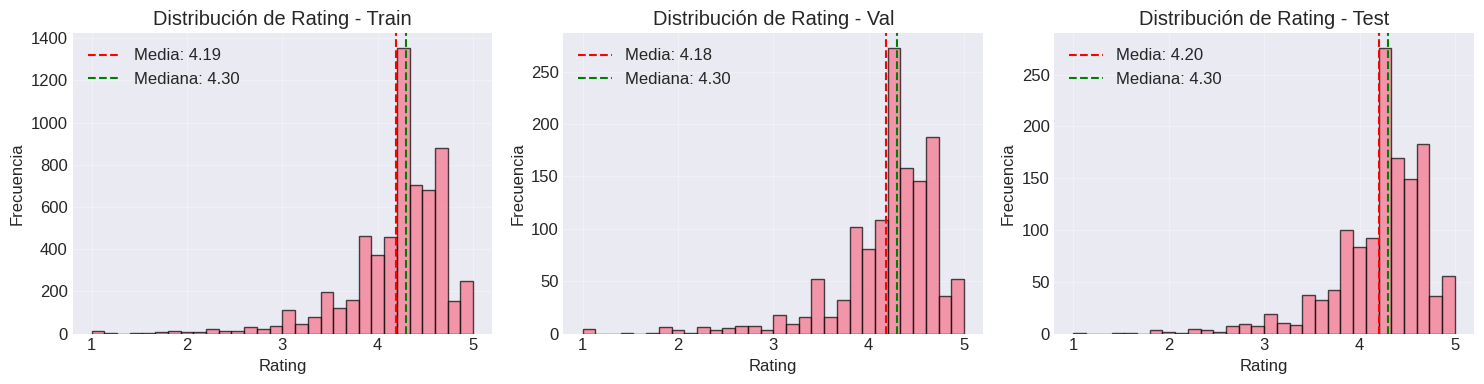


Divisi√≥n estratificada completada exitosamente
IMPORTANTE: A partir de ahora, SOLO usaremos 'train' para calcular estad√≠sticas


In [360]:
from sklearn.model_selection import train_test_split

print("=" * 80)
print("PASO 4: DIVISI√ìN ESTRATIFICADA DEL DATASET".center(80))
print("=" * 80)

# Estado antes de dividir
print(f"\nDataset despu√©s de limpieza b√°sica:")
print(f"  Total de registros: {len(df_clean):,}")
print(f"  Rating faltantes: {df_clean['Rating'].isnull().sum():,} ({df_clean['Rating'].isnull().sum()/len(df_clean)*100:.2f}%)")

# 1. ELIMINAR filas sin Rating (no podemos entrenar con ellas)
df_model = df_clean.dropna(subset=['Rating']).copy()
print(f"\nDespu√©s de eliminar filas sin Rating:")
print(f"  Registros disponibles para modelado: {len(df_model):,}")
print(f"  Registros descartados: {len(df_clean) - len(df_model):,}")

# 2. DIVISI√ìN ESTRATIFICADA: Train (70%), Temp (30%)
print("\n" + "-" * 80)
print("Dividiendo dataset (estratificado por Rating)...")
print("-" * 80)

# Crear bins de Rating para estratificaci√≥n m√°s robusta
df_model['rating_bin'] = pd.cut(df_model['Rating'], bins=[0, 3, 4, 4.5, 5], labels=['Low', 'Medium', 'High', 'VeryHigh'])

train, temp = train_test_split(
    df_model,
    test_size=0.30,
    stratify=df_model['rating_bin'],
    random_state=42
)

# 3. Dividir Temp en Val (50%) y Test (50%) ‚Üí 15% y 15% del total
val, test = train_test_split(
    temp,
    test_size=0.50,
    stratify=temp['rating_bin'],
    random_state=42
)

# Eliminar columna auxiliar de binning
train = train.drop(columns=['rating_bin'])
val = val.drop(columns=['rating_bin'])
test = test.drop(columns=['rating_bin'])

# Reindexar para evitar problemas
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

print(f"\nDivisi√≥n completada:")
print(f"  Train: {len(train):,} registros ({len(train)/len(df_model)*100:.1f}%)")
print(f"  Val:   {len(val):,} registros ({len(val)/len(df_model)*100:.1f}%)")
print(f"  Test:  {len(test):,} registros ({len(test)/len(df_model)*100:.1f}%)")

# 4. VERIFICAR ESTRATIFICACI√ìN (distribuci√≥n de Rating debe ser similar)
print("\n" + "-" * 80)
print("Verificaci√≥n de estratificaci√≥n:")
print("-" * 80)

rating_dist = pd.DataFrame({
    'Train_mean': [train['Rating'].mean()],
    'Val_mean': [val['Rating'].mean()],
    'Test_mean': [test['Rating'].mean()],
    'Train_std': [train['Rating'].std()],
    'Val_std': [val['Rating'].std()],
    'Test_std': [test['Rating'].std()]
})
display(rating_dist.round(3))

# Visualizaci√≥n de distribuciones
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, data) in zip(axes, [('Train', train), ('Val', val), ('Test', test)]):
    ax.hist(data['Rating'], bins=30, alpha=0.7, edgecolor='black')
    ax.axvline(data['Rating'].mean(), color='red', linestyle='--', label=f'Media: {data["Rating"].mean():.2f}')
    ax.axvline(data['Rating'].median(), color='green', linestyle='--', label=f'Mediana: {data["Rating"].median():.2f}')
    ax.set_title(f'Distribuci√≥n de Rating - {name}')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Frecuencia')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDivisi√≥n estratificada completada exitosamente")
print("IMPORTANTE: A partir de ahora, SOLO usaremos 'train' para calcular estad√≠sticas")

### 2.3.7. Imputaci√≥n de Valores Faltantes (Sin Data Leakage)

---

####  Calcular estad√≠sticas **solo con `train`**

Todas las estad√≠sticas utilizadas para la imputaci√≥n (medianas, modas, etc.) se calculan **exclusivamente sobre el conjunto de entrenamiento (`train`)**.  
Esto evita que el modelo tenga acceso indirecto a informaci√≥n de validaci√≥n o prueba (futuro), previniendo as√≠ **data leakage**.

> Ejemplo: las medianas de `Size` se obtienen por combinaci√≥n `Category √ó Type` **solo a partir de `train`**, y luego se aplican a `val` y `test`.

---

#### Aplicar las mismas estad√≠sticas a `val` y `test`

Las estad√≠sticas aprendidas del `train` se reutilizan directamente en los conjuntos de validaci√≥n y prueba.  
No se recalculan en esos conjuntos, lo que asegura **consistencia en la imputaci√≥n** y **evita fuga de informaci√≥n**.

> Si una categor√≠a no existe en `train`, se aplica una **mediana o moda global** (fallback), calculada tambi√©n desde `train`.

---

#### Crear *flags* de valores faltantes **antes de imputar**

Antes de reemplazar los valores nulos, se generan columnas binarias (`_missing`) que indican la presencia de datos faltantes.  
Esto permite al modelo aprender si la ausencia de informaci√≥n tiene relevancia predictiva.

> Ejemplo de *flags*:  
> `size_missing`, `content_rating_missing`, `price_missing`, `android_ver_missing`, `current_ver_missing`.

---

#### M√©todos de imputaci√≥n por variable

| Variable | M√©todo de imputaci√≥n | Nivel de agrupaci√≥n | Fallback |
|-----------|---------------------|---------------------|-----------|
| **`Size`** | Mediana | `Category √ó Type` | Mediana global |
| **`Content Rating`** | Moda | `Category` | Moda global |
| **`Android Ver`** | Moda | `Category` | Moda global |
| **`Current Ver`** | Moda | `Category` | Moda global |
| **`Price`** | `0` si `Free`, mediana si `Paid` | `Category` | Mediana global (`Paid`) |

Cada variable mantiene la misma pol√≠tica: **calcular con `train`, aplicar en `val` y `test`**.

---

#### Validaci√≥n final de imputaci√≥n

Despu√©s del proceso, se confirma que **ning√∫n conjunto tenga valores faltantes**.  
Esto garantiza que la imputaci√≥n fue exitosa y que los *flags* sean la √∫nica se√±al de ausencia original.

> Ejemplo de salida esperada:
> ```
> Train faltantes: 0
> Val faltantes: 0
> Test faltantes: 0
> ```

---

#### Beneficios de la metodolog√≠a

| Aspecto | Beneficio |
|----------|------------|
| **Prevenci√≥n de fuga de datos** | Solo se usan estad√≠sticas del conjunto de entrenamiento. |
| **Consistencia entre conjuntos** | Mismo proceso aplicado a `train`, `val` y `test`. |
| **Trazabilidad de imputaciones** | Los flags `_missing` permiten capturar patrones de ausencia. |
| **Robustez general** | Cada variable se trata seg√∫n su naturaleza (num√©rica o categ√≥rica). |



In [361]:
print("=" * 80)
print("PASO 4: IMPUTACI√ìN DE VALORES FALTANTES (Sin Data Leakage)".center(80))
print("=" * 80)

print("\nMETODOLOG√çA:")
print("  1. Calcular estad√≠sticas SOLO con train")
print("  2. Aplicar las mismas estad√≠sticas a val y test")
print("  3. Crear flags de faltantes ANTES de imputar")
print("\n" + "=" * 80)

# ==============================================================================
# CREAR FLAGS DE FALTANTES (antes de imputar)
# ==============================================================================
print("\nCreando flags de valores faltantes...")

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    df['size_missing'] = df['Size'].isnull().astype(int)
    df['content_rating_missing'] = df['Content Rating'].isnull().astype(int)
    df['android_ver_missing'] = df['Android Ver'].isnull().astype(int)
    df['current_ver_missing'] = df['Current Ver'].isnull().astype(int)
    df['price_missing'] = df['Price'].isnull().astype(int)

print("Flags creados en train, val y test")

# ==============================================================================
# 1. SIZE: Calcular medianas por Category √ó Type usando SOLO TRAIN
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando SIZE (mediana por Category √ó Type)")
print("-" * 80)

# Calcular medianas SOLO con train
size_medians = train.groupby(['Category', 'Type'])['Size'].median()
size_global_median = train['Size'].median()

print(f"Medianas calculadas con train: {len(size_medians)} grupos")
print(f"Mediana global (fallback): {size_global_median:.2f} MB")

# Funci√≥n para imputar usando mapping precalculado
def impute_size(df, medians_map, global_median):
    df = df.copy()
    for idx, row in df[df['Size'].isnull()].iterrows():
        cat, typ = row['Category'], row['Type']
        if (cat, typ) in medians_map.index:
            df.loc[idx, 'Size'] = medians_map.loc[(cat, typ)]
        else:
            df.loc[idx, 'Size'] = global_median
    return df

# Aplicar a train, val, test
train = impute_size(train, size_medians, size_global_median)
val = impute_size(val, size_medians, size_global_median)
test = impute_size(test, size_medians, size_global_median)

print(f"Size imputado en todos los conjuntos")
print(f"   Train faltantes: {train['Size'].isnull().sum()}")
print(f"   Val faltantes: {val['Size'].isnull().sum()}")
print(f"   Test faltantes: {test['Size'].isnull().sum()}")

# ==============================================================================
# 2. CONTENT RATING: Moda por Category (solo train)
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando CONTENT RATING (moda por Category)")
print("-" * 80)

content_rating_modes = train.groupby('Category')['Content Rating'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
content_rating_global_mode = train['Content Rating'].mode()[0]

print(f"Modas calculadas con train: {len(content_rating_modes)} categor√≠as")

def impute_content_rating(df, modes_map, global_mode):
    df = df.copy()
    for idx, row in df[df['Content Rating'].isnull()].iterrows():
        cat = row['Category']
        if cat in modes_map.index and pd.notna(modes_map.loc[cat]):
            df.loc[idx, 'Content Rating'] = modes_map.loc[cat]
        else:
            df.loc[idx, 'Content Rating'] = global_mode
    return df

train = impute_content_rating(train, content_rating_modes, content_rating_global_mode)
val = impute_content_rating(val, content_rating_modes, content_rating_global_mode)
test = impute_content_rating(test, content_rating_modes, content_rating_global_mode)

print(f"Content Rating imputado")

# ==============================================================================
# 3. ANDROID VER: Moda por Category (solo train)
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando ANDROID VER (moda por Category)")
print("-" * 80)

android_ver_modes = train.groupby('Category')['Android Ver'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
android_ver_global_mode = train['Android Ver'].mode()[0]

def impute_android_ver(df, modes_map, global_mode):
    df = df.copy()
    for idx, row in df[df['Android Ver'].isnull()].iterrows():
        cat = row['Category']
        if cat in modes_map.index and pd.notna(modes_map.loc[cat]):
            df.loc[idx, 'Android Ver'] = modes_map.loc[cat]
        else:
            df.loc[idx, 'Android Ver'] = global_mode
    return df

train = impute_android_ver(train, android_ver_modes, android_ver_global_mode)
val = impute_android_ver(val, android_ver_modes, android_ver_global_mode)
test = impute_android_ver(test, android_ver_modes, android_ver_global_mode)

print(f"Android Ver imputado")

# ==============================================================================
# 4. CURRENT VER: Moda por Category (solo train)
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando CURRENT VER (moda por Category)")
print("-" * 80)

current_ver_modes = train.groupby('Category')['Current Ver'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
current_ver_global_mode = train['Current Ver'].mode()[0]

def impute_current_ver(df, modes_map, global_mode):
    df = df.copy()
    for idx, row in df[df['Current Ver'].isnull()].iterrows():
        cat = row['Category']
        if cat in modes_map.index and pd.notna(modes_map.loc[cat]):
            df.loc[idx, 'Current Ver'] = modes_map.loc[cat]
        else:
            df.loc[idx, 'Current Ver'] = global_mode
    return df

train = impute_current_ver(train, current_ver_modes, current_ver_global_mode)
val = impute_current_ver(val, current_ver_modes, current_ver_global_mode)
test = impute_current_ver(test, current_ver_modes, current_ver_global_mode)

print(f"Current Ver imputado")

# ==============================================================================
# 5. PRICE: 0 si Free, mediana por Category si Paid (solo train)
# ==============================================================================
print("\n" + "-" * 80)
print("Imputando PRICE (0 si Free, mediana por Category si Paid)")
print("-" * 80)

# Calcular medianas de Price para apps Paid por Category (solo train)
price_medians_paid = train[train['Type'] == 'Paid'].groupby('Category')['Price'].median()
price_global_median_paid = train[train['Type'] == 'Paid']['Price'].median()

def impute_price(df, medians_paid_map, global_median_paid):
    df = df.copy()
    # Free apps ‚Üí 0
    mask_free = (df['Type'] == 'Free') & df['Price'].isnull()
    df.loc[mask_free, 'Price'] = 0
    
    # Paid apps ‚Üí mediana por Category
    for idx, row in df[(df['Type'] == 'Paid') & df['Price'].isnull()].iterrows():
        cat = row['Category']
        if cat in medians_paid_map.index and pd.notna(medians_paid_map.loc[cat]):
            df.loc[idx, 'Price'] = medians_paid_map.loc[cat]
        else:
            df.loc[idx, 'Price'] = global_median_paid
    return df

train = impute_price(train, price_medians_paid, price_global_median_paid)
val = impute_price(val, price_medians_paid, price_global_median_paid)
test = impute_price(test, price_medians_paid, price_global_median_paid)

print(f"Price imputado")

# ==============================================================================
# RESUMEN FINAL
# ==============================================================================
print("\n" + "=" * 80)
print("IMPUTACI√ìN COMPLETADA SIN DATA LEAKAGE")
print("=" * 80)

print("\nValores faltantes restantes:")
for name, df in [('Train', train), ('Val', val), ('Test', test)]:
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if len(missing) == 0:
        print(f"  {name}: Sin valores faltantes")
    else:
        print(f"  {name}: {missing.to_dict()}")

print("\nFlags de trazabilidad creados:")
print(f"  - size_missing")
print(f"  - content_rating_missing")
print(f"  - android_ver_missing")
print(f"  - current_ver_missing")
print(f"  - price_missing")

           PASO 4: IMPUTACI√ìN DE VALORES FALTANTES (Sin Data Leakage)           

METODOLOG√çA:
  1. Calcular estad√≠sticas SOLO con train
  2. Aplicar las mismas estad√≠sticas a val y test
  3. Crear flags de faltantes ANTES de imputar


Creando flags de valores faltantes...
Flags creados en train, val y test

--------------------------------------------------------------------------------
Imputando SIZE (mediana por Category √ó Type)
--------------------------------------------------------------------------------
Medianas calculadas con train: 59 grupos
Mediana global (fallback): 14.00 MB
Size imputado en todos los conjuntos
   Train faltantes: 0
   Val faltantes: 0
   Test faltantes: 0

--------------------------------------------------------------------------------
Imputando CONTENT RATING (moda por Category)
--------------------------------------------------------------------------------
Modas calculadas con train: 33 categor√≠as
Content Rating imputado

-------------------------

### 2.3.7. Transformaciones de Variables Num√©ricas (Sin Data Leakage)

En esta etapa se aplicaron transformaciones dise√±adas para **reducir la asimetr√≠a**, **mejorar la interpretabilidad** y **preparar las variables num√©ricas** para los modelos, garantizando que ninguna transformaci√≥n utilizara informaci√≥n de validaci√≥n o prueba.

---

#### 2.3.7.1. Log-transformaciones

Se aplicaron transformaciones logar√≠tmicas a variables con distribuciones altamente sesgadas y colas largas.  
Estas transformaciones se realizaron **de forma directa (sin estad√≠sticos derivados)**, por lo que **no generan data leakage**.

**Variables transformadas:**
- `Reviews_log = log1p(Reviews)`
- `Installs_log = log1p(Installs Numeric)`
- `Size_log = log1p(Size)`

**Resultados en el conjunto de entrenamiento:**
- `Reviews_log`: Media = **8.26**, Mediana = **8.44**  
- `Installs_log`: Media = **12.18**, Mediana = **13.12**  
- `Size_log`: Media = **2.64**, Mediana = **2.64**

> Estas transformaciones suavizan la escala exponencial de las variables y mejoran la linealidad con respecto al target.


---

#### 2.3.7.3. Variables binarias derivadas

Se generaron nuevas variables booleanas basadas en reglas de negocio fijas, lo que facilita que el modelo capture relaciones no lineales simples.

**Variables creadas:**
- `is_free`: 1 si la app es gratuita (`Type == 'Free'`) ‚Üí **5798 apps (93.2%)**
- `is_large_app`: 1 si el tama√±o > 50 MB  
- `has_high_installs`: 1 si `Installs Numeric > 1,000,000` ‚Üí **1793 apps (28.8%)**
- `is_top_category`: 1 si pertenece a `FAMILY` o `GAME`
- `is_everyone_rated`: 1 si `Content Rating == 'Everyone'`
- `large_and_popular`: combinaci√≥n de `is_large_app` & `has_high_installs`

> Estas variables mejoran la capacidad del modelo para identificar patrones de negocio relevantes (por ejemplo, apps grandes y populares tienden a obtener mejores ratings).



In [362]:
print("=" * 80)
print("PASO 5: TRANSFORMACIONES DE VARIABLES NUMERICAS (Sin Data Leakage)".center(80))
print("=" * 80)

# ==============================================================================
# 1. LOG-TRANSFORMACIONES (sin data leakage, son transformaciones puntuales)
# ==============================================================================
print("\nAplicando transformaciones logar√≠tmicas...")
print("-" * 80)

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    df['Reviews_log'] = np.log1p(df['Reviews'])
    df['Installs_log'] = np.log1p(df['Installs Numeric'])
    df['Size_log'] = np.log1p(df['Size'])

print("Variables originales eliminadas tras log-transformaci√≥n: Reviews, Installs Numeric, Size")
print("Transformaciones log aplicadas a train, val, test")
print(f"\n   Train - Reviews_log: Media {train['Reviews_log'].mean():.2f}, Mediana {train['Reviews_log'].median():.2f}")
print(f"   Train - Installs_log: Media {train['Installs_log'].mean():.2f}, Mediana {train['Installs_log'].median():.2f}")
print(f"   Train - Size_log: Media {train['Size_log'].mean():.2f}, Mediana {train['Size_log'].median():.2f}")


# ==============================================================================
# 2. VARIABLES BINARIAS (sin data leakage, son reglas fijas)
# ==============================================================================
print("\n\nCreando variables binarias...")
print("-" * 80)

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    df['is_free'] = (df['Type'] == 'Free').astype(int)
    df['is_large_app'] = (df['Size'] > 50).astype(int)
    df['has_high_installs'] = (df['Installs Numeric'] > 1000000).astype(int)
    df['is_top_category'] = df['Category'].isin(['FAMILY', 'GAME']).astype(int)
    df['is_everyone_rated'] = (df['Content Rating'] == 'Everyone').astype(int)
    df['large_and_popular'] = (df['is_large_app'] & df['has_high_installs']).astype(int)

print("Variables binarias creadas")
print(f"\n   Train - is_free: {train['is_free'].sum()} ({train['is_free'].mean()*100:.1f}%)")
print(f"   Train - has_high_installs: {train['has_high_installs'].sum()} ({train['has_high_installs'].mean()*100:.1f}%)")

print("\nTransformaciones completadas sin data leakage")

       PASO 5: TRANSFORMACIONES DE VARIABLES NUMERICAS (Sin Data Leakage)       

Aplicando transformaciones logar√≠tmicas...
--------------------------------------------------------------------------------
Variables originales eliminadas tras log-transformaci√≥n: Reviews, Installs Numeric, Size
Transformaciones log aplicadas a train, val, test

   Train - Reviews_log: Media 8.26, Mediana 8.44
   Train - Installs_log: Media 12.18, Mediana 13.12
   Train - Size_log: Media 2.64, Mediana 2.64


Creando variables binarias...
--------------------------------------------------------------------------------
Variables binarias creadas

   Train - is_free: 5798 (93.2%)
   Train - has_high_installs: 1793 (28.8%)

Transformaciones completadas sin data leakage


### 2.3.8. Creacion de Variables Derivadas (Feature Engineering B√°sico)

Creamos nuevas variables combinando informacion existente para capturar patrones mas complejos, y eliminamos aquellas redundantes (procesos intermedios, reemplazadas por log1p, etc), que no nos brindan se√±al predictiva:


In [363]:
print("=" * 80)
print("PASO 6: FEATURE ENGINEERING (Sin Data Leakage)".center(80))
print("=" * 80)

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    df['review_rate'] = df['Reviews'] / (df['Installs Numeric'] + 1)
    df['Last Updated Parsed'] = pd.to_datetime(df['Last Updated'], errors='coerce')
    reference_date = pd.to_datetime('2025-10-02')
    df['days_since_update'] = (reference_date - df['Last Updated Parsed']).dt.days
    df['update_recency'] = pd.cut(
        df['days_since_update'],
        bins=[-1, 30, 90, 180, 365, 730, 10000],
        labels=['<1 month', '1-3 months', '3-6 months', '6-12 months', '1-2 years', '>2 years']
    )
    df['size_per_install'] = df['Size'] / (df['Installs Numeric'] + 1)
    

print("\nCalculando popularity score (normalizadores desde train)...")
installs_min_train = train['Installs Numeric'].min()
installs_max_train = train['Installs Numeric'].max()
reviews_min_train = train['Reviews'].min()
reviews_max_train = train['Reviews'].max()

for df_name, df in [('train', train), ('val', val), ('test', test)]:
    installs_norm = (df['Installs Numeric'] - installs_min_train) / (installs_max_train - installs_min_train)
    reviews_norm = (df['Reviews'] - reviews_min_train) / (reviews_max_train - reviews_min_train)
    df['popularity_score'] = (installs_norm * 0.7 + reviews_norm * 0.3) * 100

print("Features derivadas creadas para obtener se√±al predictiva, sin data leakage")

print("------------------------")


print("Eliminaci√≥n de columnas redudantes")

redundant_cols = [
    'Reviews', 'Installs Numeric', 'Size', 'Installs', 'Genres', 'Last Updated', 'Last Updated Parsed',
    'Current Ver', 'Android Ver', 'days_since_update'
]


for df in [train, val, test]:
    for col in redundant_cols:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
print("Columnas redundantes eliminadas antes del encoding.")


                 PASO 6: FEATURE ENGINEERING (Sin Data Leakage)                 

Calculando popularity score (normalizadores desde train)...
Features derivadas creadas para obtener se√±al predictiva, sin data leakage
------------------------
Eliminaci√≥n de columnas redudantes
Columnas redundantes eliminadas antes del encoding.


### 2.3.9 Manejo de categor√≠as raras en la variable `Category`

En esta secci√≥n se agrupan las categor√≠as poco frecuentes dentro de la variable `Category`.  
El objetivo es reducir el impacto del desbalance categ√≥rico y evitar que categor√≠as con muy pocos registros afecten el aprendizaje del modelo.

Para ello, se define un **umbral (`threshold = 70`)** sobre el conjunto de entrenamiento.  
Todas las categor√≠as con frecuencia menor a 70 se agrupan en una nueva categor√≠a denominada **"Other"**.  
Posteriormente, se aplica el mismo mapeo al conjunto de validaci√≥n y prueba, garantizando coherencia entre los tres splits y evitando fuga de informaci√≥n.


In [364]:
threshold = 70
freq_train = train['Category'].value_counts()
main_cats = freq_train[freq_train >= threshold].index.tolist()


def map_to_other(df, col, keep):
    df = df.copy()
    df[col] = df[col].apply(lambda x: x if x in keep else 'Other')
    return df

train = map_to_other(train, 'Category', set(main_cats))
val   = map_to_other(val,   'Category', set(main_cats))
test  = map_to_other(test,  'Category', set(main_cats))

print(f"Categor√≠as 'Other' en train: {train['Category'].value_counts(normalize=True)['Other']}")
print(f"Categor√≠as 'Other' en validation: {val['Category'].value_counts(normalize=True)['Other']}")
print(f"Categor√≠as 'Other' en test: {test['Category'].value_counts(normalize=True)['Other']}")

Categor√≠as 'Other' en train: 0.05976863753213368
Categor√≠as 'Other' en validation: 0.05997001499250375
Categor√≠as 'Other' en test: 0.06446776611694154


### 2.3.10 Manejo de categor√≠as raras en la variable `Content Rating`

En esta secci√≥n se analizan las categor√≠as presentes en la variable `Content Rating`, con el objetivo de identificar valores poco representativos que podr√≠an introducir ruido en el modelo.

Durante la exploraci√≥n se observaron las siguientes clases principales:
- **Everyone**
- **Teen**
- **Mature 17+**
- **Everyone 10+**

Y dos categor√≠as extremadamente raras:
- **Adults only 18+** (2 registros)
- **Unrated** (1 registro)

Dado que estas √∫ltimas representan menos del **0.05 %** del total de observaciones, se decidi√≥ **eliminarlas directamente** en lugar de agruparlas bajo una categor√≠a "Other".  
Esta decisi√≥n se justifica porque su frecuencia es demasiado baja para aportar se√±al estad√≠stica y no se espera que aparezcan con relevancia en datos futuros.

In [365]:
train = train[~train['Content Rating'].isin(['Adults only 18+', 'Unrated'])].copy()
val   = val[~val['Content Rating'].isin(['Adults only 18+', 'Unrated'])].copy()
test  = test[~test['Content Rating'].isin(['Adults only 18+', 'Unrated'])].copy()

print(f"Content Rating en train: {train['Content Rating'].value_counts()}")
print("-----")
print(f"Content Rating en validation: {val['Content Rating'].value_counts()}")
print("-----")
print(f"Content Rating en test: {test['Content Rating'].value_counts()}")


Content Rating en train: Content Rating
Everyone        4960
Teen             714
Mature 17+       293
Everyone 10+     254
Name: count, dtype: int64
-----
Content Rating en validation: Content Rating
Everyone        1086
Teen             147
Mature 17+        56
Everyone 10+      45
Name: count, dtype: int64
-----
Content Rating en test: Content Rating
Everyone        1049
Teen             161
Mature 17+        62
Everyone 10+      61
Name: count, dtype: int64


### 2.3.11 Resumen final del dataset dividido (Train / Validation / Test)

En esta secci√≥n se presenta un **resumen general** del estado final de los datos tras todo el proceso de limpieza, depuraci√≥n y divisi√≥n en conjuntos de entrenamiento, validaci√≥n y prueba.  
El objetivo es validar que las transformaciones previas (eliminaci√≥n de duplicados, tratamiento de valores faltantes, correcci√≥n de outliers y manejo de variables categ√≥ricas) se hayan aplicado correctamente y que las tres particiones mantengan coherencia estructural y estad√≠stica.



In [366]:
# ==============================================
# 2.3.11 - Resumen final del dataset dividido
# ORIGINAL vs (TRAIN / VALIDATION / TEST)
# ==============================================

import pandas as pd
from IPython.display import display

print("=" * 80)
print("RESUMEN FINAL: DATASET DIVIDIDO (Train / Validation / Test)".center(80))
print("=" * 80)

print("\n" + "=" * 40)
print("COMPARACI√ìN: ORIGINAL vs SPLITS")
print("=" * 40)

# ---------- Funci√≥n de resumen por dataset ----------
def get_summary(df, name):
    return [
        name,
        f"{len(df):,}",
        f"{len(df.columns)}",
        f"{df.duplicated().sum():,}",
        f"{df['Rating'].isnull().sum():,}" if 'Rating' in df.columns else "N/A",
        f"{df['Size'].isnull().sum():,}" if 'Size' in df.columns else "N/A",
        f"{df['Price'].isnull().sum():,}" if 'Price' in df.columns else "N/A",
        f"{df['Type'].isnull().sum():,}" if 'Type' in df.columns else "N/A",
        f"{((df['Rating'] > 5) | (df['Rating'] < 1)).sum():,}" if 'Rating' in df.columns else "N/A",
        f"{df.memory_usage(deep=True).sum() / 1024**2:.2f}"
    ]

# ---------- Construcci√≥n de la tabla comparativa ----------
summary_rows = [
    get_summary(applications_data, "Original"),
    get_summary(train, "Train"),
    get_summary(val, "Validation"),
    get_summary(test, "Test")
]

comparison = pd.DataFrame(
    summary_rows,
    columns=[
        "Conjunto",
        "Total de registros",
        "Total de columnas",
        "Duplicados",
        "Rating faltantes",
        "Size faltantes",
        "Price faltantes",
        "Type faltantes",
        "Ratings inv√°lidos (>5 o <1)",
        "Memoria (MB)"
    ]
)

display(comparison)

# ---------- Listado de features por split ----------
print("\n" + "=" * 40)
print("LISTADO DE FEATURES EN CADA CONJUNTO")
print("=" * 40)
for name, df in [('Train', train), ('Validation', val), ('Test', test)]:
    print(f"\n{name}: Total de features = {len(df.columns)}")
    print("columnas:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:3d}. {col}")
    if len(df.columns) > 30:
        print("  ...")
    print("√öltimas 5 columnas:")
    for i, col in enumerate(df.columns[-5:], len(df.columns)-4):
        print(f"  {i:3d}. {col}")

# ---------- Estad√≠sticas descriptivas (num√©ricas) ----------
print("\n" + "=" * 40)
print("ESTAD√çSTICAS DESCRIPTIVAS (Variables num√©ricas - Train)")
print("=" * 40)

# Variables num√©ricas m√°s relevantes para el an√°lisis
key_numeric = [
    'Rating', 
    'Price', 
    'review_rate', 
    'size_per_install', 
    'popularity_score',
    'Reviews_log',
    'Installs_log',
    'Size_log'
]

# Filtrar solo las columnas que existen realmente en el dataset
available_numeric = [col for col in key_numeric if col in train.columns]

# Mostrar la descripci√≥n
if available_numeric:
    print(f"\nVariables incluidas en el an√°lisis: {', '.join(available_numeric)}")
    display(train[available_numeric].describe().round(3).T)
else:
    print("No se encontraron las columnas seleccionadas en el conjunto de entrenamiento.")

# ---------- Mensaje final ----------
print("\n" + "=" * 80)
print("TRANSFORMACI√ìN Y DIVISI√ìN COMPLETADAS EXITOSAMENTE")
print("=" * 80)
print(f"\nConjuntos disponibles: train, val, test")
print(f"Dimensiones finales: Train={train.shape[0]:,}, Val={val.shape[0]:,}, Test={test.shape[0]:,}")
print(f"Memoria utilizada (train): {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


          RESUMEN FINAL: DATASET DIVIDIDO (Train / Validation / Test)           

COMPARACI√ìN: ORIGINAL vs SPLITS


Conjunto Total de registros Total de columnas Duplicados  \
0    Original             10,841                14        483   
1       Train              6,221                24          1   
2  Validation              1,334                24          0   
3        Test              1,333                24          0   

  Rating faltantes Size faltantes Price faltantes Type faltantes  \
0            1,474          1,696               1              1   
1                0            N/A               0              0   
2                0            N/A               0              0   
3                0            N/A               0              0   

  Ratings inv√°lidos (>5 o <1) Memoria (MB)  
0                           1         5.98  
1                           0         2.40  
2                           0         0.50  
3                           0         0.52


LISTADO DE FEATURES EN CADA CONJUNTO

Train: Total de features = 24
columnas:
    1. App
    2. Category
    3. Rating
    4. Type
    5. Price
    6. Content Rating
    7. size_missing
    8. content_rating_missing
    9. android_ver_missing
   10. current_ver_missing
   11. price_missing
   12. Reviews_log
   13. Installs_log
   14. Size_log
   15. is_free
   16. is_large_app
   17. has_high_installs
   18. is_top_category
   19. is_everyone_rated
   20. large_and_popular
   21. review_rate
   22. update_recency
   23. size_per_install
   24. popularity_score
√öltimas 5 columnas:
   20. large_and_popular
   21. review_rate
   22. update_recency
   23. size_per_install
   24. popularity_score

Validation: Total de features = 24
columnas:
    1. App
    2. Category
    3. Rating
    4. Type
    5. Price
    6. Content Rating
    7. size_missing
    8. content_rating_missing
    9. android_ver_missing
   10. current_ver_missing
   11. price_missing
   12. Reviews_log
   13. Installs_lo

count  mean   std  min  25%   50%   75%    max
Rating           6221.00  4.19  0.52 1.00 4.00  4.30  4.50   5.00
Price            6221.00  1.06 17.30 0.00 0.00  0.00  0.00 399.99
review_rate      6221.00  0.04  0.07 0.00 0.01  0.02  0.04   2.00
size_per_install 6221.00  0.03  0.32 0.00 0.00  0.00  0.00  12.50
popularity_score 6221.00  1.29  6.71 0.00 0.00  0.04  0.38 100.00
Reviews_log      6221.00  8.26  3.82 0.69 5.14  8.44 11.16  18.17
Installs_log     6221.00 12.18  3.81 0.69 9.21 13.12 15.43  20.72
Size_log         6221.00  2.65  1.01 0.01 1.93  2.64  3.40   4.62


TRANSFORMACI√ìN Y DIVISI√ìN COMPLETADAS EXITOSAMENTE

Conjuntos disponibles: train, val, test
Dimensiones finales: Train=6,221, Val=1,334, Test=1,333
Memoria utilizada (train): 2.40 MB


### 2.3.12 An√°lisis de relevancia de variables mediante Informaci√≥n Mutua

En esta etapa se aplic√≥ la m√©trica de **Informaci√≥n Mutua** para cuantificar la dependencia estad√≠stica entre cada variable num√©rica y la variable objetivo `Rating`.  
Este an√°lisis permite identificar qu√© variables aportan mayor informaci√≥n al modelo, sin asumir relaciones lineales, ayudando a seleccionar los predictores m√°s relevantes antes del entrenamiento.

#### 2.3.12.1. Interpretaci√≥n de resultados

La gr√°fica muestra la **importancia relativa de cada variable** seg√∫n su grado de informaci√≥n compartida con `Rating`.  
Se observa que:

- **`popularity_score`** es la variable m√°s influyente, con el valor de informaci√≥n mutua m√°s alto (~0.34). Esto indica una fuerte relaci√≥n entre la popularidad de la app (descargas y rese√±as combinadas) y su calificaci√≥n promedio.  
- **`Reviews_log`** y **`review_rate`** tambi√©n presentan una asociaci√≥n significativa con el rating, lo que refuerza la idea de que la participaci√≥n y satisfacci√≥n de los usuarios est√°n estrechamente ligadas a la puntuaci√≥n final.  
- Variables como **`Installs_log`**, **`size_per_install`** y **`has_high_installs`** muestran una contribuci√≥n media, aportando informaci√≥n adicional relacionada con la escala de uso y la eficiencia de la aplicaci√≥n.  
- En contraste, variables como **`Price`**, **`price_missing`**, **`is_top_category`** o **`current_ver_missing`** tienen una influencia muy baja, lo que sugiere que su aporte al modelo ser√≠a marginal.


['Price', 'size_missing', 'content_rating_missing', 'android_ver_missing', 'current_ver_missing', 'price_missing', 'Reviews_log', 'Installs_log', 'Size_log', 'is_free', 'is_large_app', 'has_high_installs', 'is_top_category', 'is_everyone_rated', 'large_and_popular', 'review_rate', 'size_per_install', 'popularity_score']


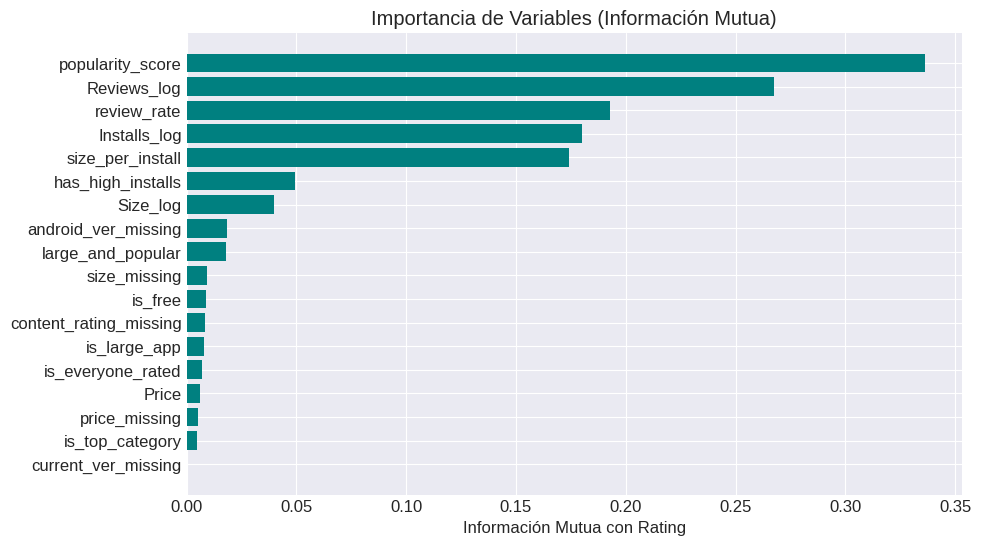

Variable  MI_Score
17        popularity_score      0.34
6              Reviews_log      0.27
15             review_rate      0.19
7             Installs_log      0.18
16        size_per_install      0.17
11       has_high_installs      0.05
8                 Size_log      0.04
3      android_ver_missing      0.02
14       large_and_popular      0.02
1             size_missing      0.01
9                  is_free      0.01
2   content_rating_missing      0.01
10            is_large_app      0.01
13       is_everyone_rated      0.01
0                    Price      0.01
5            price_missing      0.01
12         is_top_category      0.00
4      current_ver_missing      0.00


Variables con baja informaci√≥n mutua (<0.01) que pueden eliminarse inicialmente:
  - size_missing
  - is_free
  - content_rating_missing
  - is_large_app
  - is_everyone_rated
  - Price
  - price_missing
  - is_top_category
  - current_ver_missing

Variables seleccionadas para modelado inicial (9):
['popularity_score', 'Reviews_log', 'review_rate', 'Installs_log', 'size_per_install', 'has_high_installs', 'Size_log', 'android_ver_missing', 'large_and_popular']


In [367]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# Selecci√≥n de variables predictoras: solo num√©ricas (int, float)
target = 'Rating'
ignore_cols = [target]
X_cols = [
    col for col in train.columns
    if col not in ignore_cols
    and pd.api.types.is_numeric_dtype(train[col])
]

print(X_cols)

X = train[X_cols].copy()
y = train[target]

# Calcular informaci√≥n mutua
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_df = pd.DataFrame({'Variable': X_cols, 'MI_Score': mi_scores}).sort_values('MI_Score', ascending=False)

# Visualizaci√≥n
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Variable'], mi_df['MI_Score'], color='teal')
plt.xlabel('Informaci√≥n Mutua con Rating')
plt.title('Importancia de Variables (Informaci√≥n Mutua)')
plt.gca().invert_yaxis()
plt.show()

# Mostrar tabla ordenada
display(mi_df)

# Eliminar variables con MI muy baja (<0.01)
low_mi_vars = mi_df[mi_df['MI_Score'] < 0.01]['Variable'].tolist()
print(f"\nVariables con baja informaci√≥n mutua (<0.01) que pueden eliminarse inicialmente:")
for v in low_mi_vars:
    print(f"  - {v}")

# Variables relevantes para modelado
selected_vars = mi_df[mi_df['MI_Score'] >= 0.01]['Variable'].tolist()
print(f"\nVariables seleccionadas para modelado inicial ({len(selected_vars)}):")
print(selected_vars)

### 2.3.13 Verificaci√≥n de correlaci√≥n y an√°lisis de multicolinealidad

En esta etapa se evalu√≥ la **correlaci√≥n lineal entre las variables seleccionadas** tras el an√°lisis de informaci√≥n mutua, con el fin de detectar posibles casos de **multicolinealidad**.  
La multicolinealidad ocurre cuando dos o m√°s variables est√°n fuertemente correlacionadas entre s√≠, lo que puede distorsionar la interpretaci√≥n de los modelos y afectar la estabilidad de los coeficientes en algoritmos lineales (por ejemplo, regresi√≥n o modelos basados en pesos).

Para ello, se calcul√≥ la **matriz de correlaci√≥n de Pearson** considerando √∫nicamente las variables num√©ricas seleccionadas y se visualiz√≥ mediante un mapa de calor.

#### 2.3.13.1. Interpretaci√≥n de la matriz

- Se observa una **alta correlaci√≥n entre `Reviews_log` e `Installs_log` (r ‚âà 0.96)**, lo que indica que ambas variables transmiten informaci√≥n muy similar: las aplicaciones con muchas rese√±as suelen tener tambi√©n un gran n√∫mero de instalaciones.  
  Por tanto, mantener ambas podr√≠a ser redundante en modelos sensibles a multicolinealidad.  
- Tambi√©n existe una correlaci√≥n considerable entre **`has_high_installs`** y las variables anteriores (`Installs_log` y `Reviews_log`), dado que esta variable binaria deriva del mismo concepto (nivel alto de descargas).  
- El resto de las variables presentan correlaciones moderadas o bajas, lo cual es positivo: **no se evidencia colinealidad severa** fuera del grupo relacionado con las m√©tricas de descargas y rese√±as.  
- Variables como `review_rate`, `size_per_install`, `popularity_score`, `Size_log` y `large_and_popular` muestran relaciones d√©biles o independientes entre s√≠, lo que las hace adecuadas para conservarlas.

#### 2.3.13.2. Decisi√≥n
Se toma la decisi√≥n de eliminar Installs_log dado que Reviews_Log explica su comportamiento.

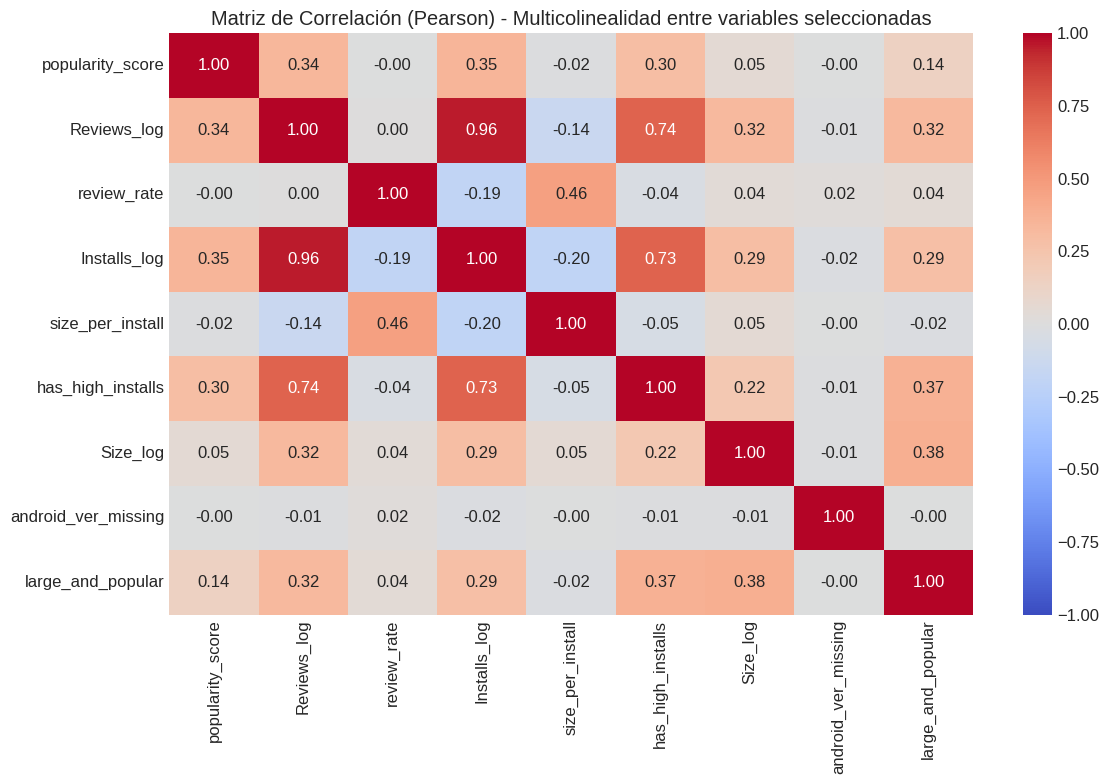


Pares de variables con posible multicolinealidad (|corr| > 0.8):
  ‚Ä¢ Reviews_log y Installs_log: +0.96


In [368]:
# An√°lisis de multicolinealidad entre variables seleccionadas por informaci√≥n mutua
def multicollinearity_analysis(df, selected_vars):
    """
    Analiza la multicolinealidad entre las variables seleccionadas (sin incluir el target).
    """
    # Solo variables num√©ricas seleccionadas (sin el target)
    selected_numeric = [v for v in selected_vars if pd.api.types.is_numeric_dtype(df[v])]
    corr_matrix = df[selected_numeric].corr(method='pearson')

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Matriz de Correlaci√≥n (Pearson) - Multicolinealidad entre variables seleccionadas')
    plt.tight_layout()
    plt.show()

    # Mostrar pares con alta correlaci√≥n (|corr| > 0.8)
    print("\nPares de variables con posible multicolinealidad (|corr| > 0.8):")
    high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    for col in high_corr.columns:
        for idx in high_corr.index:
            corr_val = high_corr.loc[idx, col]
            if abs(corr_val) > 0.8:
                print(f"  ‚Ä¢ {idx} y {col}: {corr_val:+.2f}")

# Ejecutar el an√°lisis de multicolinealidad solo para las variables seleccionadas
multicollinearity_analysis(train, selected_vars)

In [369]:
for df in [train, val, test]:
    if 'Installs_log' in df.columns:
        df.drop(columns=['Installs_log'], inplace=True)
print("Columna 'Installs_log' eliminada por multicolinealidad con 'Reviews_log'.")

Columna 'Installs_log' eliminada por multicolinealidad con 'Reviews_log'.


### 2.3.14 Codificaci√≥n de variables categ√≥ricas (One-Hot Encoding)

En esta fase se transformaron las variables categ√≥ricas del conjunto de datos en formato num√©rico mediante **One-Hot Encoding (OHE)**.  
Este proceso es esencial para los modelos de machine learning que requieren valores num√©ricos de entrada, permitiendo representar cada categor√≠a como una columna binaria independiente.

#### 2.3.14.1. Proceso aplicado

1. Se identificaron todas las variables categ√≥ricas (`object` o `category`) excepto el identificador `App`.  
2. Se aplic√≥ **One-Hot Encoding** sobre estas variables, creando una columna por cada categor√≠a posible.  
3. Para garantizar consistencia entre los conjuntos `train`, `validation` y `test`, se implement√≥ una funci√≥n que:
   - Asegura que **todos los conjuntos contengan las mismas columnas codificadas**.  
   - Agrega columnas faltantes con valores `0` en caso de que una categor√≠a no est√© presente en un conjunto espec√≠fico.  
   - Elimina cualquier columna extra que no est√© en la estructura original de `train`.  
4. Finalmente, los tres conjuntos (`train`, `val`, `test`) quedaron alineados en n√∫mero y orden de columnas, listos para el modelado.

#### 2.3.14.2. Resultado

Tras la codificaci√≥n:
- Se convirtieron correctamente todas las variables categ√≥ricas a formato num√©rico.  
- El n√∫mero de columnas aument√≥, reflejando las nuevas variables dummy generadas por OHE.  
- Se verific√≥ que la estructura final es id√©ntica en los tres conjuntos:  

| Conjunto | Total de columnas |
|-----------|------------------|
| **Train** | 57 |
| **Validation** | igual a Train |
| **Test** | igual a Train |


In [370]:
cat_cols = [
    c for c in train.columns
    if (train[c].dtype == 'object' or str(train[c].dtype) == 'category')
    and c not in ['App']
]

print(cat_cols)
train_dummies = pd.get_dummies(train, columns=cat_cols, drop_first=False)
dummy_cols = [col for col in train_dummies.columns if col not in train.columns or col in cat_cols]

def align_dummies(df, cat_cols, dummy_cols):
    df_dummies = pd.get_dummies(df, columns=cat_cols, drop_first=False)
    for col in dummy_cols:
        if col not in df_dummies.columns:
            df_dummies[col] = 0
    extra_cols = set(df_dummies.columns) - set(train_dummies.columns)
    df_dummies = df_dummies.drop(columns=list(extra_cols))
    df_dummies = df_dummies[train_dummies.columns]
    return df_dummies

val_dummies = align_dummies(val, cat_cols, dummy_cols)
test_dummies = align_dummies(test, cat_cols, dummy_cols)

train = train_dummies.copy()
val = val_dummies.copy()
test = test_dummies.copy()

print(f"Variables categ√≥ricas codificadas y alineadas: Train={train.shape[1]}, Val={val.shape[1]}, Test={test.shape[1]}")


['Category', 'Type', 'Content Rating', 'update_recency']
Variables categ√≥ricas codificadas y alineadas: Train=56, Val=56, Test=56
